In [ ]:
!pip install kornia
!pip install fiftyone
!pip install fiftyone-db-ubuntu2204
!pip install git+https://github.com/boto/botocore


In [ ]:
# -*- coding: utf-8 -*-

import torch.nn.functional as Fun
import torch.nn as nn
import torch.nn.functional as F
import torch

import torchvision as tv
from torchvision import transforms

from collections import OrderedDict

import matplotlib.pyplot as plt
import cv2, math
import numpy as np
import os, random
import time
from IPython.display import clear_output
import fiftyone.zoo as foz
import pandas as pd
from PIL import Image

import kornia

# Trenowanie modelu superrozdzielczego RLFN

In [ ]:
### ------------------- Select if sr model is training or evaluating
### True - if train
### False - if eval
sr_training = False

In [ ]:


def _make_pair(value):
    if isinstance(value, int):
        value = (value,) * 2
    return value


def conv_layer(in_channels,
               out_channels,
               kernel_size,
               bias=True):
    """
    Re-write convolution layer for adaptive `padding`.
    """
    kernel_size = _make_pair(kernel_size)
    padding = (int((kernel_size[0] - 1) / 2),
               int((kernel_size[1] - 1) / 2))
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size,
                     padding=padding,
                     bias=bias)


def activation(act_type, inplace=True, neg_slope=0.05, n_prelu=1):
    """
    Activation functions for ['relu', 'lrelu', 'prelu'].
    Parameters
    ----------
    act_type: str
        one of ['relu', 'lrelu', 'prelu'].
    inplace: bool
        whether to use inplace operator.
    neg_slope: float
        slope of negative region for `lrelu` or `prelu`.
    n_prelu: int
        `num_parameters` for `prelu`.
    ----------
    """
    act_type = act_type.lower()
    if act_type == 'relu':
        layer = nn.ReLU(inplace)
    elif act_type == 'lrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act_type == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    else:
        raise NotImplementedError(
            'activation layer [{:s}] is not found'.format(act_type))
    return layer


def sequential(*args):
    """
    Modules will be added to the a Sequential Container in the order they
    are passed.

    Parameters
    ----------
    args: Definition of Modules in order.
    -------
    """
    if len(args) == 1:
        if isinstance(args[0], OrderedDict):
            raise NotImplementedError(
                'sequential does not support OrderedDict input.')
        return args[0]
    modules = []
    for module in args:
        if isinstance(module, nn.Sequential):
            for submodule in module.children():
                modules.append(submodule)
        elif isinstance(module, nn.Module):
            modules.append(module)
    return nn.Sequential(*modules)


def pixelshuffle_block(in_channels,
                       out_channels,
                       upscale_factor=2,
                       kernel_size=3):
    """
    Upsample features according to `upscale_factor`.
    """
    conv = conv_layer(in_channels,
                      out_channels * (upscale_factor ** 2),
                      kernel_size)
    pixel_shuffle = nn.PixelShuffle(upscale_factor)
    return sequential(conv, pixel_shuffle)


class ESA(nn.Module):
    """
    Modification of Enhanced Spatial Attention (ESA), which is proposed by
    `Residual Feature Aggregation Network for Image Super-Resolution`
    Note: `conv_max` and `conv3_` are NOT used here, so the corresponding codes
    are deleted.
    """

    def __init__(self, esa_channels, n_feats, conv):
        super(ESA, self).__init__()
        f = esa_channels
        self.conv1 = conv(n_feats, f, kernel_size=1)
        self.conv_f = conv(f, f, kernel_size=1)
        self.conv2 = conv(f, f, kernel_size=3, stride=2, padding=0)
        self.conv3 = conv(f, f, kernel_size=3, padding=1)
        self.conv4 = conv(f, n_feats, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        c1_ = (self.conv1(x))
        c1 = self.conv2(c1_)
        v_max = F.max_pool2d(c1, kernel_size=7, stride=3)
        c3 = self.conv3(v_max)
        c3 = F.interpolate(c3, (x.size(2), x.size(3)),
                           mode='bilinear', align_corners=False)
        cf = self.conv_f(c1_)
        c4 = self.conv4(c3 + cf)
        m = self.sigmoid(c4)
        return x * m


class RLFB(nn.Module):
    """
    Residual Local Feature Block (RLFB).
    """

    def __init__(self,
                 in_channels,
                 mid_channels=None,
                 out_channels=None,
                 esa_channels=16):
        super(RLFB, self).__init__()

        if mid_channels is None:
            mid_channels = in_channels
        if out_channels is None:
            out_channels = in_channels

        self.c1_r = conv_layer(in_channels, mid_channels, 3)
        self.c2_r = conv_layer(mid_channels, mid_channels, 3)
        self.c3_r = conv_layer(mid_channels, in_channels, 3)

        self.c5 = conv_layer(in_channels, out_channels, 1)
        self.esa = ESA(esa_channels, out_channels, nn.Conv2d)

        self.act = activation('lrelu', neg_slope=0.05)

    def forward(self, x):
        out = (self.c1_r(x))
        out = self.act(out)

        out = (self.c2_r(out))
        out = self.act(out)

        out = (self.c3_r(out))
        out = self.act(out)

        out = out + x
        out = self.esa(self.c5(out))

        return out

In [ ]:

class RLFN_S(nn.Module):
    """
    Residual Local Feature Network (RLFN)
    Model definition of RLFN_S in `Residual Local Feature Network for
    Efficient Super-Resolution`
    """

    def __init__(self,
                 in_channels=3,
                 out_channels=3,
                 feature_channels=48,
                 upscale=4):
        super(RLFN_S, self).__init__()

        self.conv_1 = conv_layer(in_channels,
                                       feature_channels,
                                       kernel_size=3)

        self.block_1 = RLFB(feature_channels)
        self.block_2 = RLFB(feature_channels)
        self.block_3 = RLFB(feature_channels)
        self.block_4 = RLFB(feature_channels)
        self.block_5 = RLFB(feature_channels)
        self.block_6 = RLFB(feature_channels)

        self.conv_2 = conv_layer(feature_channels,
                                       feature_channels,
                                       kernel_size=3)

        self.upsampler = pixelshuffle_block(feature_channels,
                                                  out_channels,
                                                  upscale_factor=upscale)

    def forward(self, x):
        out_feature = self.conv_1(x)

        out_b1 = self.block_1(out_feature)
        out_b2 = self.block_2(out_b1)
        out_b3 = self.block_3(out_b2)
        out_b4 = self.block_4(out_b3)
        out_b5 = self.block_5(out_b4)
        out_b6 = self.block_6(out_b5)

        out_low_resolution = self.conv_2(out_b6) + out_feature
        output = self.upsampler(out_low_resolution)

        return output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------------------------------
# load model
# --------------------------------

model = RLFN_S(in_channels=3, out_channels=3)

model.load_state_dict(torch.load( "/model/save.pth"))


<All keys matched successfully>

In [ ]:
def read_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

def uint2tensor4(img):
    img = img.numpy()
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    return torch.from_numpy(np.ascontiguousarray(img)).unsqueeze(0)

def tensor2uint(img):
    img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    return np.uint8((img*255.0).round())

In [ ]:

data_path = "/data/"

#Choose optimizer
opt =  torch.optim.Adam(model.parameters(),0.0002)

#Set input and output dimientions
LR_dim = (64, 64)
HR_dim = (256, 256)

resize_obj = tv.transforms.Resize(LR_dim)
batch_size = 32

#Transforamtions to do during loading dataset
transform = transforms.Compose([
    transforms.RandomCrop(HR_dim, pad_if_needed =True),
    transforms.ToTensor()
])

dataset = tv.datasets.ImageFolder(data_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True,batch_size=batch_size)

if sr_training:
    all_epochs = 100
    for epoch in range(all_epochs):
        #Load images from directory
        images, labels = next(iter(dataloader))
        #Move model and dataset from CPU to GPU
        gpu_model = model.to(device)
        images = images.to(device)

        # Crop crop and resize images
        HR_crop = images
        LR_crop = resize_obj(HR_crop)

        # Push images to model
        SR_img = gpu_model(LR_crop)

        #Calculate loss value and do backward poropagation
        t = l1_loss(SR_img, HR_crop)
        t.backward()
        opt.step()
        opt.zero_grad()

        if epoch % 10 == 1:
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, dpi=150, figsize=(16,16))

            print("Epoch:" + str(epoch) + "/" + str(all_epochs) +  " output loss:" + str(float(t)))
            SR_img = tensor2uint(SR_img[0])
            HR_img = tensor2uint(HR_crop[0])
            LR_img = tensor2uint(LR_crop[0])

            ax1.imshow(LR_img)
            ax3.imshow(SR_img)
            ax2.imshow(HR_img)
            ax4.imshow(cv2.resize(LR_img, HR_dim, cv2.INTER_CUBIC))

            plt.show()




In [ ]:
if sr_training:
    torch.save(model.state_dict(), "/model/save_2.pth")


In [ ]:

all_epochs = 1000
if sr_training:
    for epoch in range(all_epochs):
        images, labels = next(iter(dataloader))

        gpu_model = model.to(device)
        images = images.to(device)
        # images = uint2tensor4(images)
        HR_crop = images
        LR_crop = resize_obj(HR_crop)
        # Generate images from model
        out_im = gpu_model(LR_crop)

        t = my_loss(out_im, HR_crop)
        t.backward()
        SR_img = gpu_model(LR_crop)

        opt.step()

        opt.zero_grad()
        if epoch % 100 == 1:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=150, figsize=(16,16))

            print("Epoch:" + str(epoch) + "/" + str(all_epochs) +  " output loss:" + str(float(t)))
            SR_img = tensor2uint(SR_img[0])
            HR_img = tensor2uint(HR_crop[0])
            LR_img = tensor2uint(LR_crop[0])

            ax1.imshow(LR_img)
            ax3.imshow(SR_img)
            ax2.imshow(HR_img)

            plt.show()


In [ ]:
sr_model = model

# Zbieranie danych

In [ ]:

def read_rgb_image(path):
    """Utility function that loads an image as an RGB numpy aray."""
    return np.asarray(Image.open(path))


In [ ]:
model=tv.models.detection.maskrcnn_resnet50_fpn(weights=tv.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)


In [ ]:
import torchvision.transforms as transforms


_ = sr_model.eval()
_ = model.eval()


In [ ]:

def rescale_by_factor(img, scale):
    img_size = (int(img.shape[1] * scale), int(img.shape[0] * scale))
    img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
    return img


def img_to_torch(img):
    return torch.stack([torch.as_tensor(img, dtype=torch.float32)], 0).swapaxes(1, 3).swapaxes(2, 3)

def torch_to_img(torch_image):
    return torch_image.swapaxes(1, 2).swapaxes(0, 2).detach().numpy()

def get_example_image(shuffle=True):
    data.shuffle()

    samples = data.take(1)
    for sample in samples:
        img =  read_rgb_image(sample.filepath) / 255.

        frame_size = np.asarray((sample.metadata["height"], sample.metadata["width"]))
        labels, masks = [],[]
        for detection in sample["ground_truth"]["detections"]:
            segmentation = detection.to_segmentation(np.zeros(frame_size))
            labels.append(detection["label"])
            masks.append(segmentation.mask)

        return img, (masks, labels)

def upscale_with_model(img, model):
    torch_img = img_to_torch(img)
    torch_sr_img = model(torch_img)
    sr_img = torch_to_img(torch_sr_img[0])
    return sr_img

def obj_detect_with_model(img, model):
    torch_img = img_to_torch(img)
    torch_img = torch_img.to(device)
    model = model.to(device)
    output = model(torch_img)
    masks = output[0]['masks'].cpu().swapaxes(2, 3).swapaxes(1, 3).detach().numpy()
    labels = output[0]['labels']


    return masks, labels

def calculate_IoU(mask_1, mask_2):
    shape = []
    mask_1 = mask_1.clip(0, 1)
    mask_2 = mask_2.clip(0 ,1)
    if mask_1.shape[0] * mask_1.shape[1] < mask_2.shape[0] * mask_2.shape[1]:
        shape = mask_1.shape
    else:
        shape = mask_2.shape

    shape = (shape[1], shape[0])
    mask_1 = cv2.resize(mask_1, dsize=shape)
    mask_2 = cv2.resize(mask_2, dsize=shape)

    overlap = mask_1 * mask_2 # Logical AND
    union = mask_1 + mask_2 # Logical OR
    union = union.clip(0,1)
    IOU = overlap.sum()/float(union.sum())

    return IOU


In [ ]:
!wget https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
f = open("coco-labels-paper.txt", "r")
index_to_label_list = f.readlines()
index_to_label_list = [i.replace('\n', "") for i in index_to_label_list]
f.close()


--2023-08-23 19:06:09--  https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702 [text/plain]
Saving to: ‘coco-labels-paper.txt.1’

coco-labels-paper.t 100%[===================>]     702  --.-KB/s    in 0s      

2023-08-23 19:06:09 (33.0 MB/s) - ‘coco-labels-paper.txt.1’ saved [702/702]



In [ ]:
def get_detected_object(gt_mask, gt_label, masks, labels):
    iou_list = np.zeros(len(masks))
    for i, candidate in enumerate(masks):
        if labels[i] == gt_label:
            iou_list[i] = calculate_IoU(gt_mask, candidate)

    winner = iou_list.argmax()
    if iou_list[winner] < 0.3:
        return -1
    else:
        return winner

In [ ]:
def get_data_from_detection(masks, labels, gt_masks, gt_labels):
    found = []
    ious = []
    idxs = []
    for gt_mask, gt_label in zip(gt_masks, gt_labels):
        gt_mask = gt_mask.reshape((*gt_mask.shape, 1))
        found.append(False)
        ious.append(0)
        idxs.append(-1)
        try:
            found[-1] = True
            # one_obj_list = left_propper_label_in_masks(masks, labels, gt_label)
            detected_idx = get_detected_object(gt_mask, gt_label, masks, labels)
            if detected_idx == -1:
                found[-1] = False
            else:
                iou = calculate_IoU(gt_mask, masks[detected_idx])
                idxs[-1] = detected_idx
                ious[-1] = iou
        except:
            found[-1] = False
    return found, ious, idxs

In [ ]:
def one_img_detection(img, gt_masks, gt_labels, imshow=False):

    # ------------------------ Low res img detection ---------------------------
    start = time.time()
    lr_masks, lr_labels = obj_detect_with_model(img, model)
    end = time.time()
    lr_time = end - start

    # ------------------------ High res img detection --------------------------
    start = time.time()
    upscaled_img = upscale_with_model(img, sr_model)

    hr_masks, hr_labels = obj_detect_with_model(upscaled_img, model)
    end = time.time()
    hr_time = end - start

    lr_founds, lr_ious, lr_idxs = get_data_from_detection(lr_masks, lr_labels, gt_masks, gt_labels)

    hr_founds, hr_ious, hr_idxs = get_data_from_detection(hr_masks, hr_labels, gt_masks, gt_labels)

    lr_times = [lr_time] * len(lr_founds)
    hr_times = [hr_time] * len(hr_founds)


    if imshow:
        for i, mask in enumerate(gt_masks):
            figure, axis = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
            axis[0, 0].imshow(mask)
            axis[1, 0].imshow(img)
            axis[0, 0].set_title(f"Oryginalny obraz")
            print("LR idx " + str(lr_idxs))
            print("lr_ious: " + str(len(lr_ious)))

            print("idxs: " + str(len(lr_idxs)))
            if lr_idxs[i] != -1:
                axis[0, 1].imshow(img * lr_masks[lr_idxs[i]])
                axis[1, 1].imshow(img)
                axis[0, 1].set_title(f"Segmentacja obiektu po pomniejszeniu, IoU {lr_ious[i]:.3f}")

            if hr_idxs[i] != -1:
                axis[0, 2].imshow(upscaled_img * hr_masks[hr_idxs[i]])
                axis[1, 2].imshow(upscaled_img)
                axis[0, 2].set_title(f"Segmentacja obiektu po wykorzystaniu sieci SR, IoU {hr_ious[i]:.3f}")



    return lr_founds, lr_ious, lr_times, hr_founds, hr_ious, hr_times


In [ ]:

def full_detection(data, detection_data, scale, end=-1, imshow=False):
    for num, sample in enumerate(data.iter_samples()):
        clear_output()
        print("actual scale: " + str(scale))
        print("sample: " + str(num))
        img =  read_rgb_image(sample.filepath) / 255.

        frame_size = np.asarray((sample.metadata["height"], sample.metadata["width"]))
        labels, masks = [],[]
        try:
            for detection in sample["ground_truth"]["detections"]:
                segmentation = detection.to_segmentation(np.zeros(frame_size))
                labels.append(detection["label"])
                masks.append(segmentation.mask.clip(0, 1))
            if len(img.shape) == 3 and img.shape[2] == 3:

                labels_idx, mask_sizes, shapes, filenames = [], [], [], []

                resized_img = rescale_by_factor(img, scale)
                for label, mask in zip(labels, masks):
                    labels_idx.append(index_to_label_list.index(label) + 1)
                    mask_sizes.append(int(mask.sum() * scale))
                    filenames.append(sample.filepath.split("/")[-1])
                    shapes.append(resized_img.shape)
                lf, li, lt, hf, hi, ht = one_img_detection(resized_img, masks, labels_idx, imshow=imshow)


                for one_result in zip(lf, li, lt, hf, hi, ht, mask_sizes, shapes, labels, filenames):
                    detection_data.append(one_result)
            else:
                print("wrong img shape")
        except TypeError as te:
            print('Not iterable')
        if end != -1 and num >= end:
            break

    return detection_data

In [ ]:
data = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations"],
    max_samples=50,
)

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


Loading existing dataset 'coco-2017-validation-50'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'coco-2017-validation-50'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
session.dataset = data

In [ ]:
data = data.shuffle()
detection_data = full_detection(data, [], 0.3, end=0, imshow=True)

In [ ]:

scales = [ 0.1, 0.3, 0.5, 0.7]

for scale in scales:
    detection_data = []
    detection_data = full_detection(data, detection_data, scale)
    output_filename = "/outputs/data_" + str(scale) + ".csv"
    df = pd.DataFrame(detection_data)
    df.columns = ["Low res det", "Low res IoU","Low res time", "High res det", "High res IoU", "High res time", "Obj size", "Shape", "Name", "Filepath"]

    df.to_csv(output_filename)


# Analiza danych


In [ ]:
datasets = [None, None, None, None]
output_filename = "/outputs/data_"
for i, val in enumerate([0.1, 0.3, 0.5, 0.7]):
    datasets[i] = pd.read_csv(output_filename + str(val) + ".csv")

In [ ]:
for df in datasets:
    df['Shape'] = df['Shape'].map(lambda x: eval(x))

In [ ]:
datasets[0]

Unnamed: 0  Low res det  Low res IoU  Low res time  High res det  \
0              0         True     0.322917      0.198776         False   
1              1         True     0.814765      0.198776          True   
2              2        False     0.000000      0.198776         False   
3              3         True     0.354139      0.198776         False   
4              4        False     0.000000      0.198776         False   
...          ...          ...          ...           ...           ...   
7154        7154         True     0.474713      0.138973          True   
7155        7155        False     0.000000      0.138973         False   
7156        7156        False     0.000000      0.138973         False   
7157        7157        False     0.000000      0.138973         False   
7158        7158        False     0.000000      0.138973         False   

      High res IoU  High res time  Obj size        Shape          Name  \
0         0.000000       0.210803        53  (42, 64, 3)  potted plant   
1         0.854921       0.210803      1324  (42, 64, 3)            tv   
2         0.000000       0.210803       569  (42, 64, 3)            tv   
3         0.000000       0.210803       220  (42, 64, 3)         chair   
4         0.000000       0.210803       189  (42, 64, 3)         chair   
...            ...            ...       ...          ...           ...   
7154      0.495226       0.220532      2508  (33, 50, 3)        laptop   
7155      0.000000       0.220532       201  (33, 50, 3)           cup   
7156      0.000000       0.220532        16  (33, 50, 3)         spoon   
7157      0.000000       0.220532         7  (33, 50, 3)         spoon   
7158      0.000000       0.220532       101  (33, 50, 3)    cell phone   

              Filepath  
0     000000000139.jpg  
1     000000000139.jpg  
2     000000000139.jpg  
3     000000000139.jpg  
4     000000000139.jpg  
...                ...  
7154  000000119233.jpg  
7155  000000119233.jpg  
7156  000000119233.jpg  
7157  000000119233.jpg  
7158  000000119233.jpg  

[7159 rows x 11 columns]

# Średnie rozmiary obrazków

In [ ]:
for ds in datasets:
    ds_size = len(ds)
    x = 0
    y = 0
    for i in ds["Shape"]:
        x += i[0]
        y += i[1]
    print(x/ds_size, y/ds_size)


imsizes=[]
for i in datasets[0]["Shape"]:
    imsizes.append(i[0] * i[1] * 10)

47.089258276295574 58.51487637938259
141.94859617264981 175.711412208409
236.78767984355358 292.9333705824836
331.4176560972203 410.07026120966617


# Detekcja

In [ ]:
det = [[],[]]
for ds in datasets:
    det[0].append(sum(ds["Low res det"]))
    det[1].append(sum(ds["High res det"]))
det

[[1284, 4281, 5496, 5834], [2134, 4683, 5574, 5834]]

Text(0, 0.5, 'Liczba detekcji')

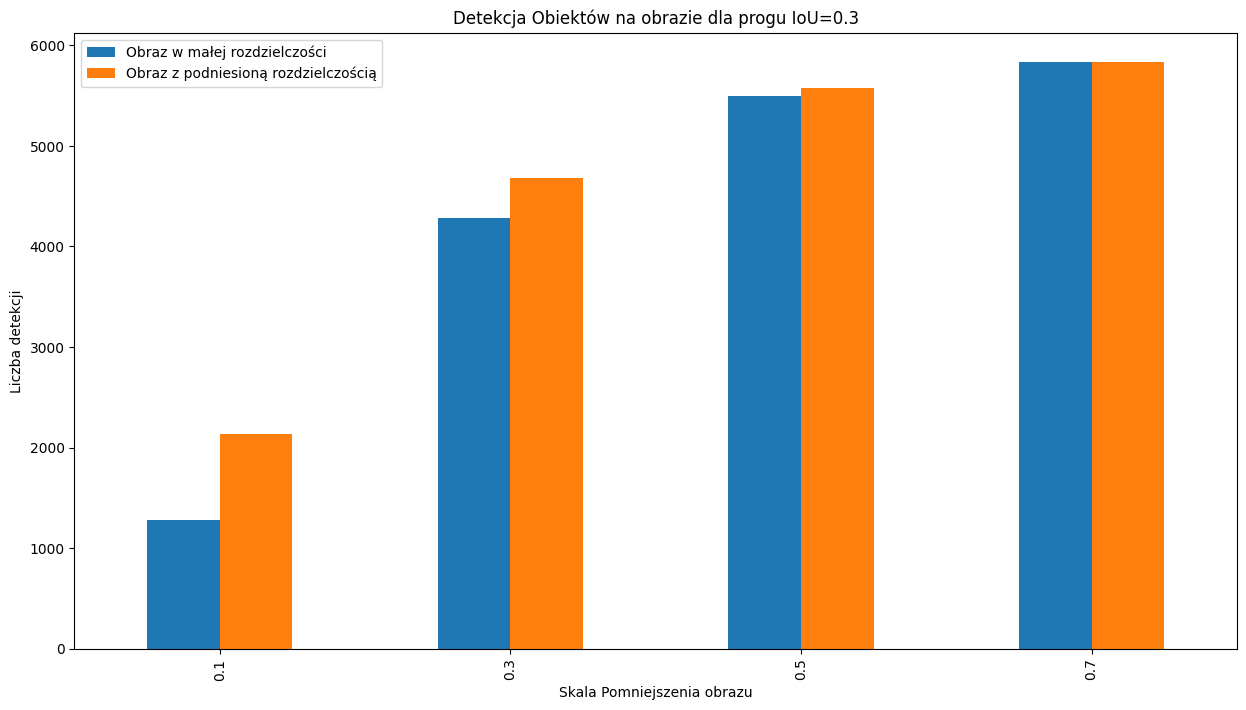

In [ ]:
import matplotlib.pyplot as plt

plotdata = pd.DataFrame({
    "Obraz w małej rozdzielczości":det[0],
    "Obraz z podniesioną rozdzielczością":det[1]},
    index=["0.1", "0.3", "0.5", "0.7"])

plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("Detekcja Obiektów na obrazie dla progu IoU=0.3")
plt.xlabel("Skala Pomniejszenia obrazu")
plt.ylabel("Liczba detekcji")


Text(0, 0.5, 'Liczba detekcji')

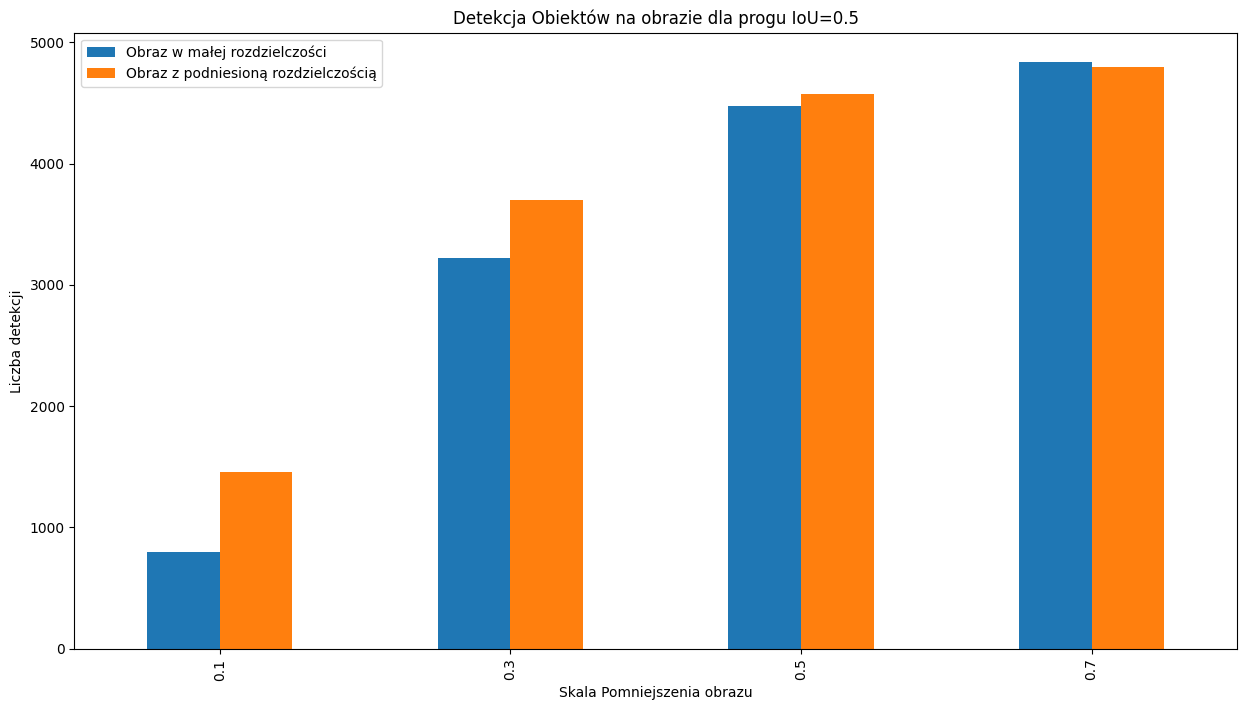

In [ ]:
det = [[],[]]
for ds in datasets:
    det[0].append(sum(ds["Low res IoU"] > 0.5))
    det[1].append(sum(ds["High res IoU"] > 0.5))


plotdata = pd.DataFrame({
    "Obraz w małej rozdzielczości":det[0],
    "Obraz z podniesioną rozdzielczością":det[1]},
    index=["0.1", "0.3", "0.5", "0.7"])

plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("Detekcja Obiektów na obrazie dla progu IoU=0.5")
plt.xlabel("Skala Pomniejszenia obrazu")
plt.ylabel("Liczba detekcji")


#Detekcja w zależnosci od rozmiarów obiektu

High 0.1 Mean: 0.35321940060083956 Std: 0.3249824787630927
Low 0.1 Mean: 0.2612601932903915 Std: 0.27654926393645035
High 0.3 Mean: 0.5863571069772867 Std: 0.33095883861171055
Low 0.3 Mean: 0.5357615311850329 Std: 0.3433926755771609
High 0.5 Mean: 0.6705638006679636 Std: 0.30698432706772455
Low 0.5 Mean: 0.6332618390261225 Std: 0.32875524584901
High 0.7 Mean: 0.6666552999457412 Std: 0.30737285706187434
Low 0.7 Mean: 0.6591309754725203 Std: 0.3215296463616293


Text(0.5, 0.98, 'Detekcja obiektu w zależności od rozmiaru')

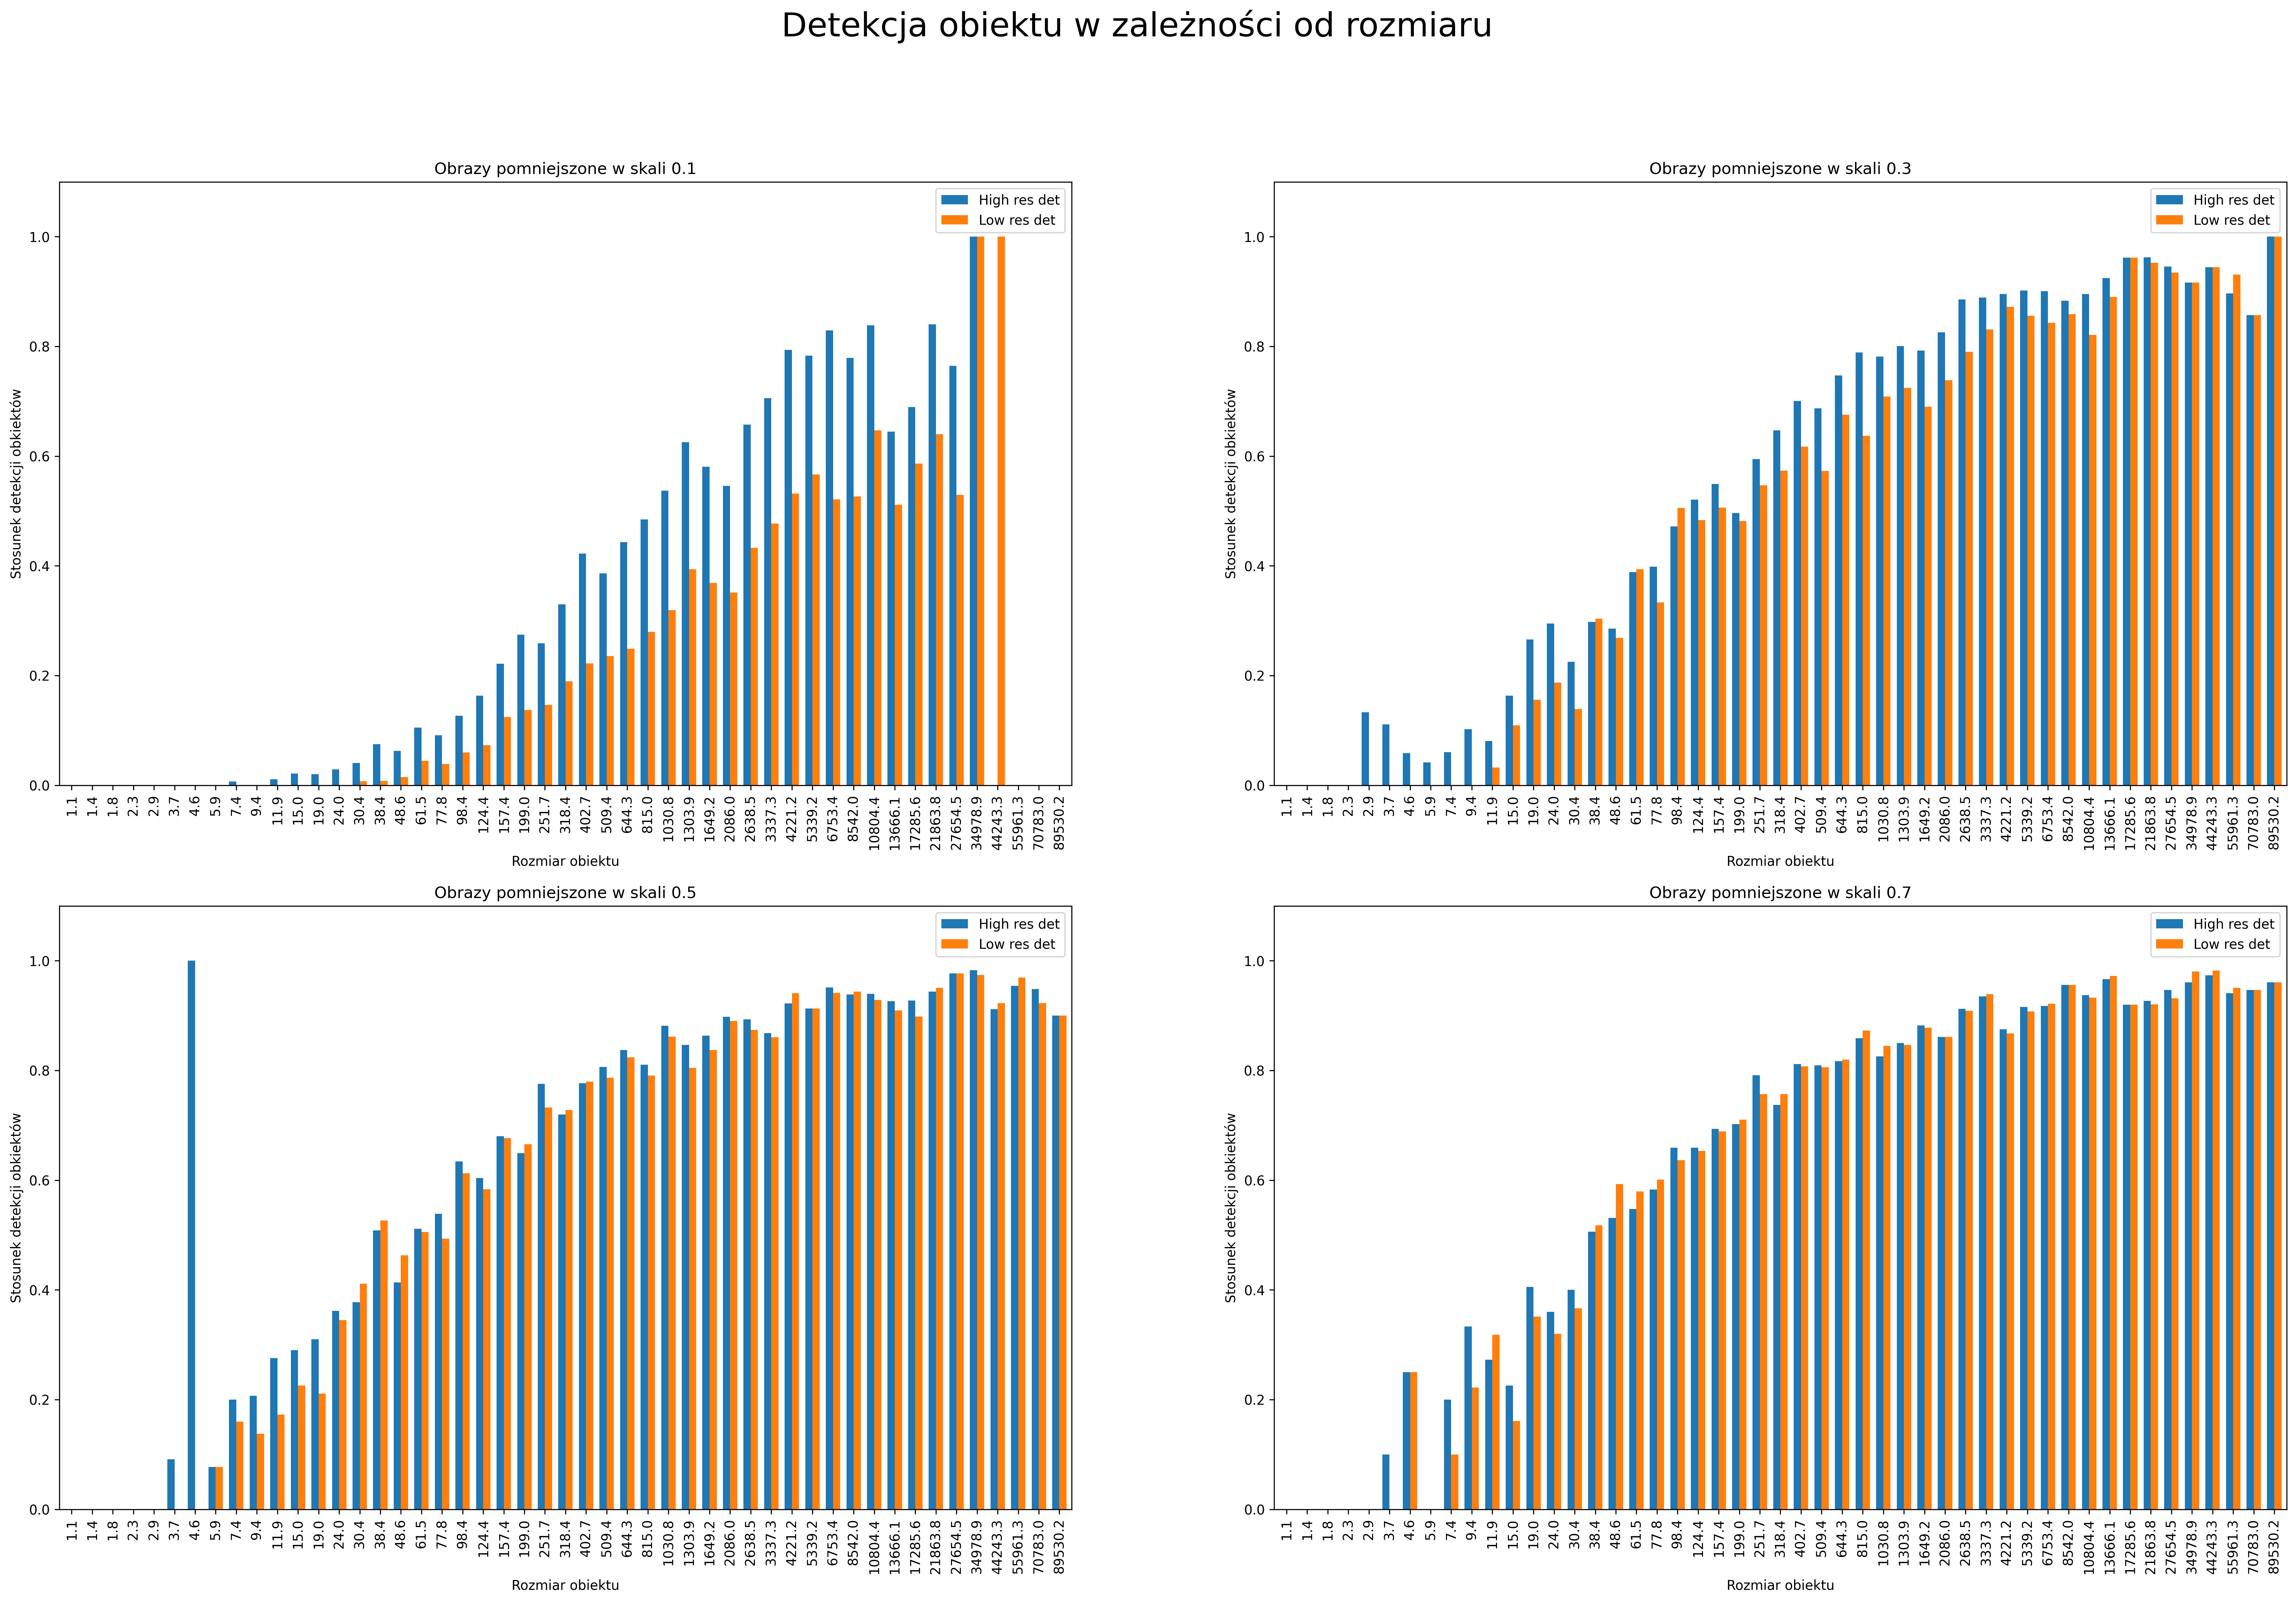

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(30,18), dpi=300)
scales = [0.1, 0.3, 0.5, 0.7]


for i, ds in enumerate(datasets):

    ds["Img size"] = imsizes
    ds["Obj img scale"] = ds["Obj size"] / ds["Img size"]
    ds = ds[['High res det', 'Low res det', "Obj size"]]
    ranges = np.logspace(np.log10(1),np.log10(100000.0), 50)


    answ = ds.groupby(pd.cut(ds['Obj size'], ranges)).mean()[['High res det', 'Low res det']]
    answ.index = answ.index.map(lambda i: np.around(i.mid, 1))
    answ.plot(kind="bar",xlim=True, ax=ax[int(i/2), i%2], width=0.7)

    ax[int(i/2), i%2].title.set_text("Obrazy pomniejszone w skali " + str(scales[i]))
    ax[int(i/2), i%2].set_xlabel("Rozmiar obiektu")

    ax[int(i/2), i%2].set_ylabel("Stosunek detekcji obkiektów")
    ax[int(i/2), i%2].set_ylim([0, 1.1])
    h_res_mean = answ["High res det"].mean()
    h_res_std = answ["High res det"].std()
    print("High " + str(scales[i]) + " Mean: " + str(h_res_mean) + " Std: " + str(h_res_std))

    l_res_mean = answ["Low res det"].mean()
    l_res_std = answ["Low res det"].std()
    print("Low " + str(scales[i]) + " Mean: " + str(l_res_mean) + " Std: " + str(l_res_std))

fig.suptitle("Detekcja obiektu w zależności od rozmiaru", fontsize=25)

High 0.1 Mean: 0.6974919321333157 Std: 0.2698180453620162
Low 0.1 Mean: 0.4929620372846708 Std: 0.23730302073808934
High 0.3 Mean: 0.9106577707709309 Std: 0.08931444270625839
Low 0.3 Mean: 0.8723623323538381 Std: 0.1106998221470781
High 0.5 Mean: 0.9282081734549879 Std: 0.06624963464574656
Low 0.5 Mean: 0.9187343311483913 Std: 0.07273220068710776
High 0.7 Mean: 0.9212367020160075 Std: 0.0718724798893555
Low 0.7 Mean: 0.9189219770755243 Std: 0.07031455262849098


Text(0.5, 0.98, 'Detekcja obiektu w zależności od stosunku rozmiaru obiektu do obrazka')

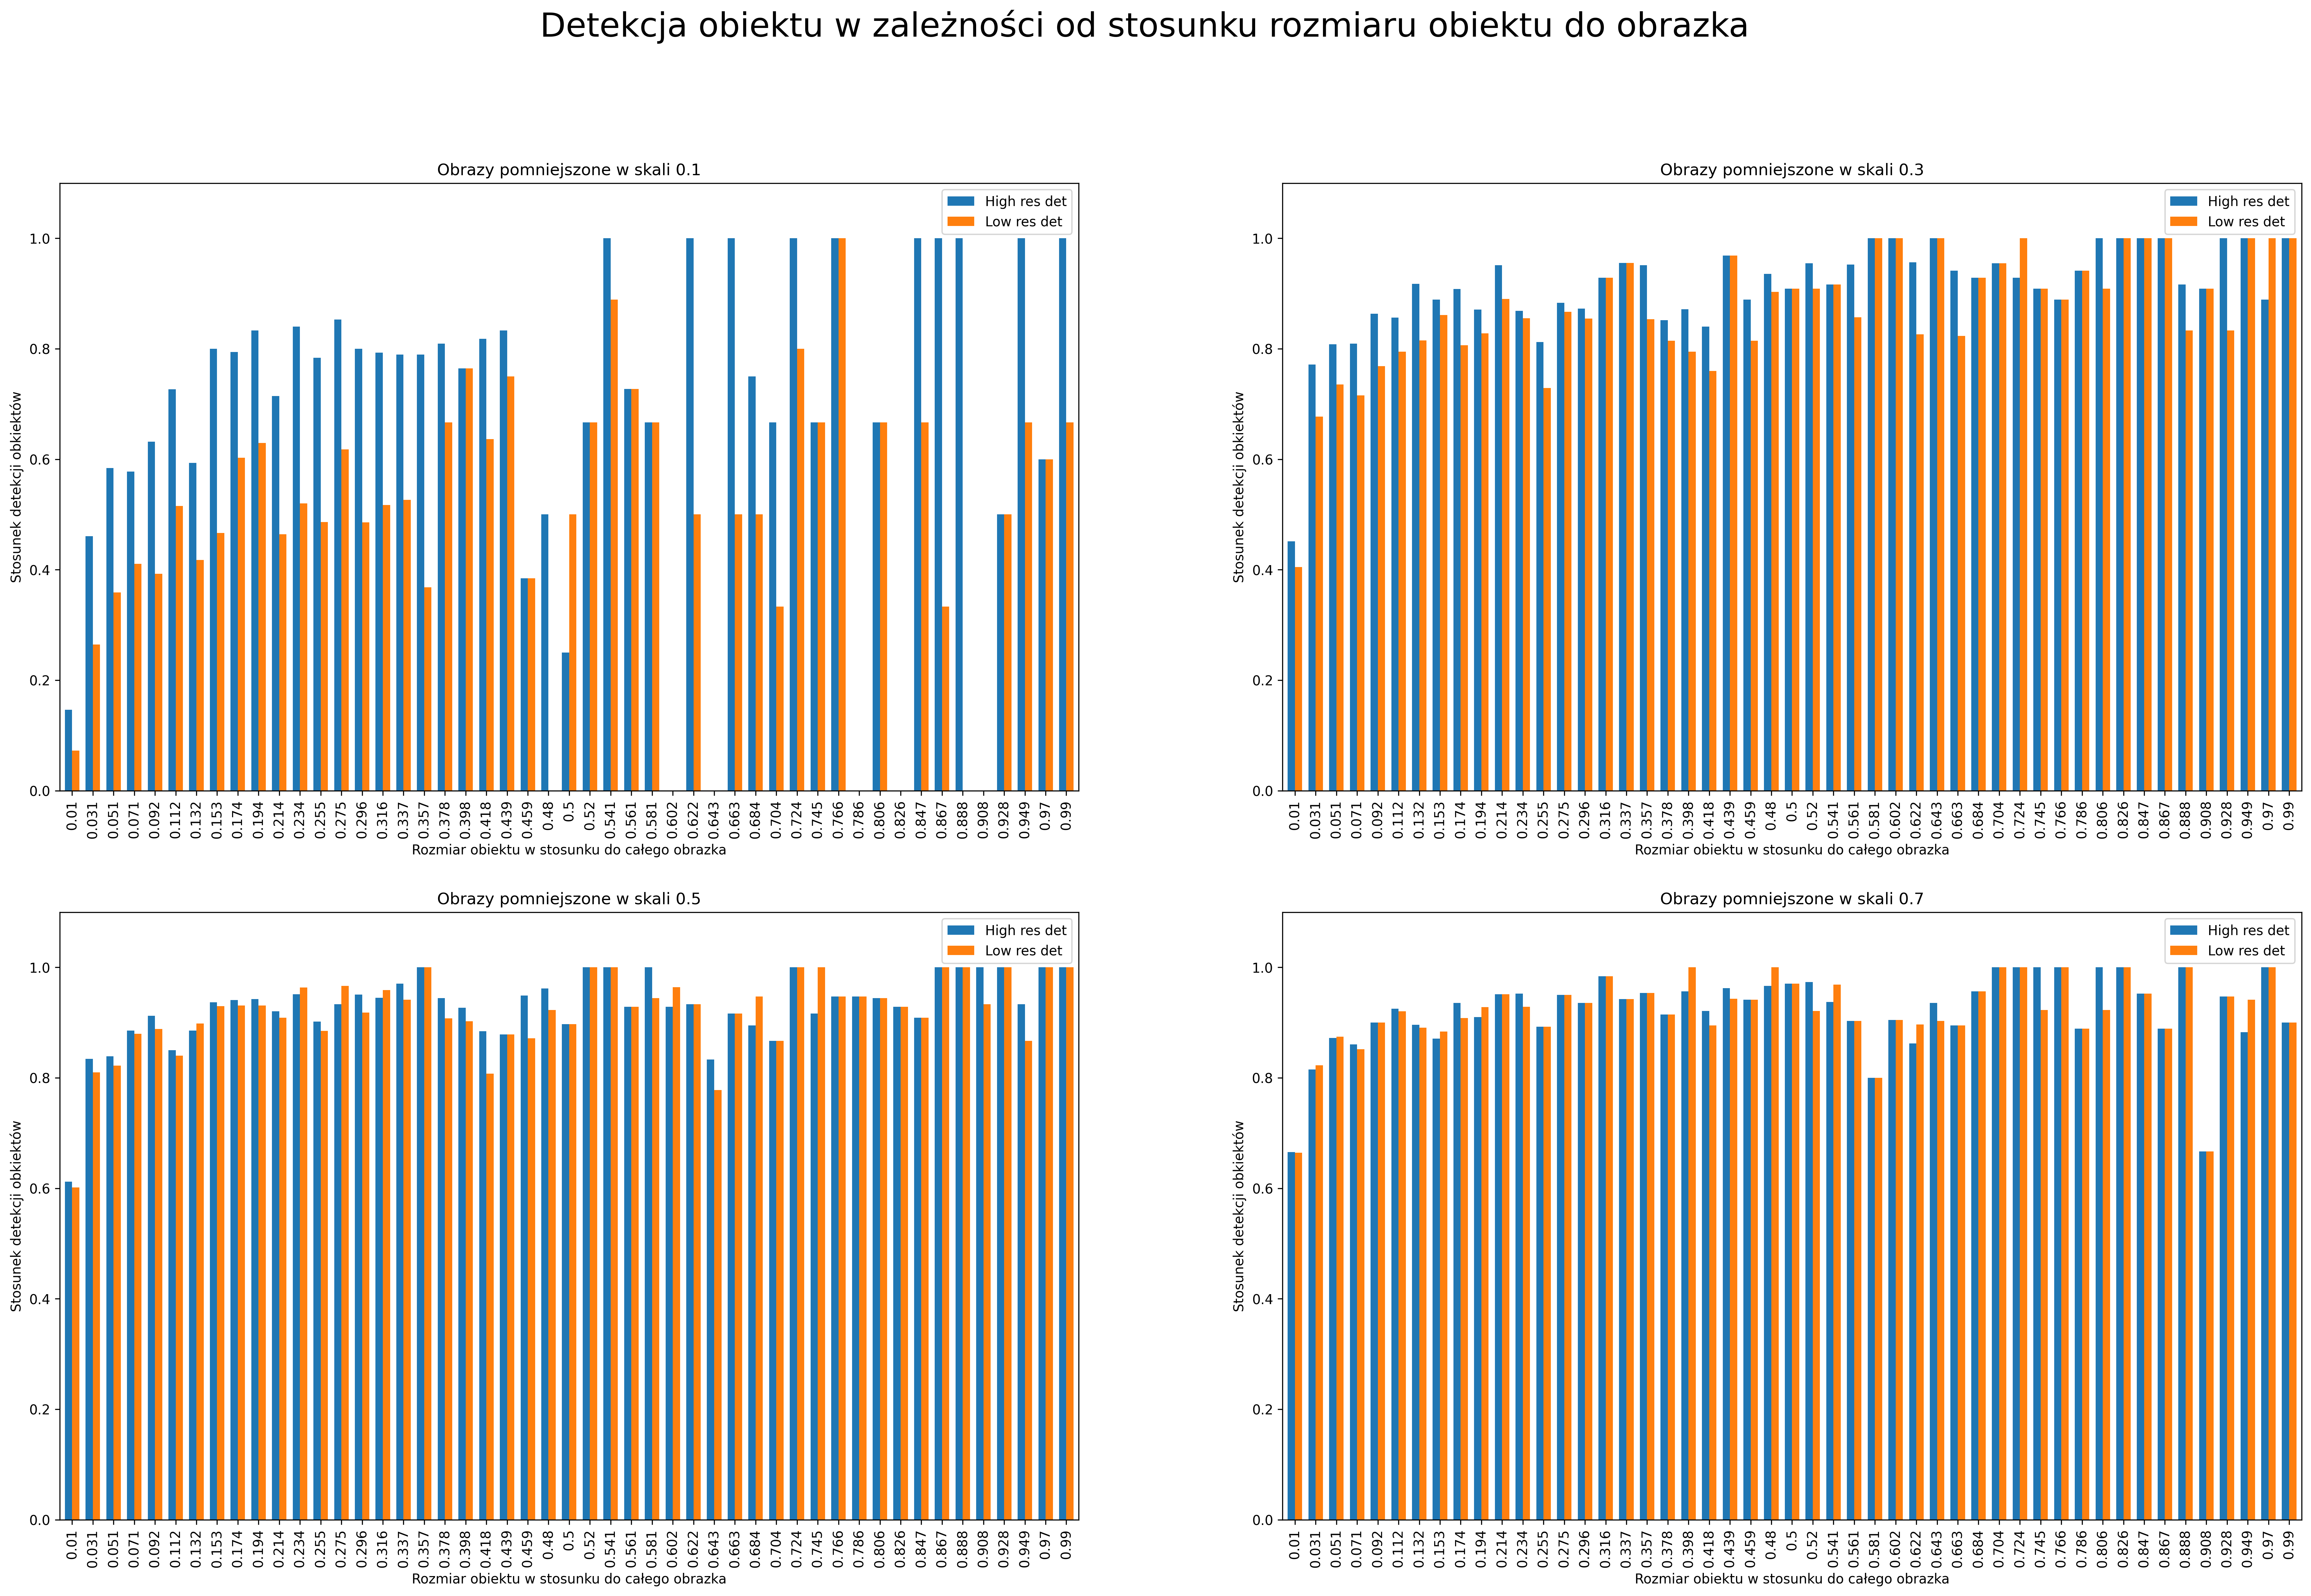

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(30,18), dpi=300)
scales = [0.1, 0.3, 0.5, 0.7]

imsizes=[]
for i in datasets[0]["Shape"]:
    imsizes.append(i[0] * i[1] * 10)

for i, ds in enumerate(datasets):

    ds["Img size"] = imsizes
    ds["Obj img scale"] = ds["Obj size"] / ds["Img size"]
    ds = ds[['High res det', 'Low res det', "Obj img scale"]]
    ranges = np.linspace(0, 1, 50)


    answ = ds.groupby(pd.cut(ds['Obj img scale'], ranges)).mean()[['High res det', 'Low res det']]
    answ.index = answ.index.map(lambda i: np.around(i.mid, 3))
    answ.plot(kind="bar", ax=ax[int(i/2), i%2], width=0.7)

    ax[int(i/2), i%2].title.set_text("Obrazy pomniejszone w skali " + str(scales[i]))
    ax[int(i/2), i%2].set_xlabel("Rozmiar obiektu w stosunku do całego obrazka")

    ax[int(i/2), i%2].set_ylabel("Stosunek detekcji obkiektów")
    ax[int(i/2), i%2].set_ylim([0, 1.1])
    h_res_mean = answ["High res det"].mean()
    h_res_std = answ["High res det"].std()
    print("High " + str(scales[i]) + " Mean: " + str(h_res_mean) + " Std: " + str(h_res_std))

    l_res_mean = answ["Low res det"].mean()
    l_res_std = answ["Low res det"].std()
    print("Low " + str(scales[i]) + " Mean: " + str(l_res_mean) + " Std: " + str(l_res_std))

fig.suptitle("Detekcja obiektu w zależności od stosunku rozmiaru obiektu do obrazka", fontsize=25)

# IoU w zależnosci od Rozmiarów


High 0.1 Mean: 0.6015876936930172 Std: 0.08298954294678733
Low 0.1 Mean: 0.5248101666686344 Std: 0.10827142269985271
High 0.3 Mean: 0.6388815792974702 Std: 0.08882489058396298
Low 0.3 Mean: 0.5932512063536801 Std: 0.12298859246546959
High 0.5 Mean: 0.6285964659110322 Std: 0.11083803257648385
Low 0.5 Mean: 0.6068569088326508 Std: 0.13746526083623647
High 0.7 Mean: 0.6199231930001076 Std: 0.11542119145892034
Low 0.7 Mean: 0.6134469998074845 Std: 0.13047071458447332


Text(0.5, 0.98, 'IoU obiektu w zależności od rozmiaru')

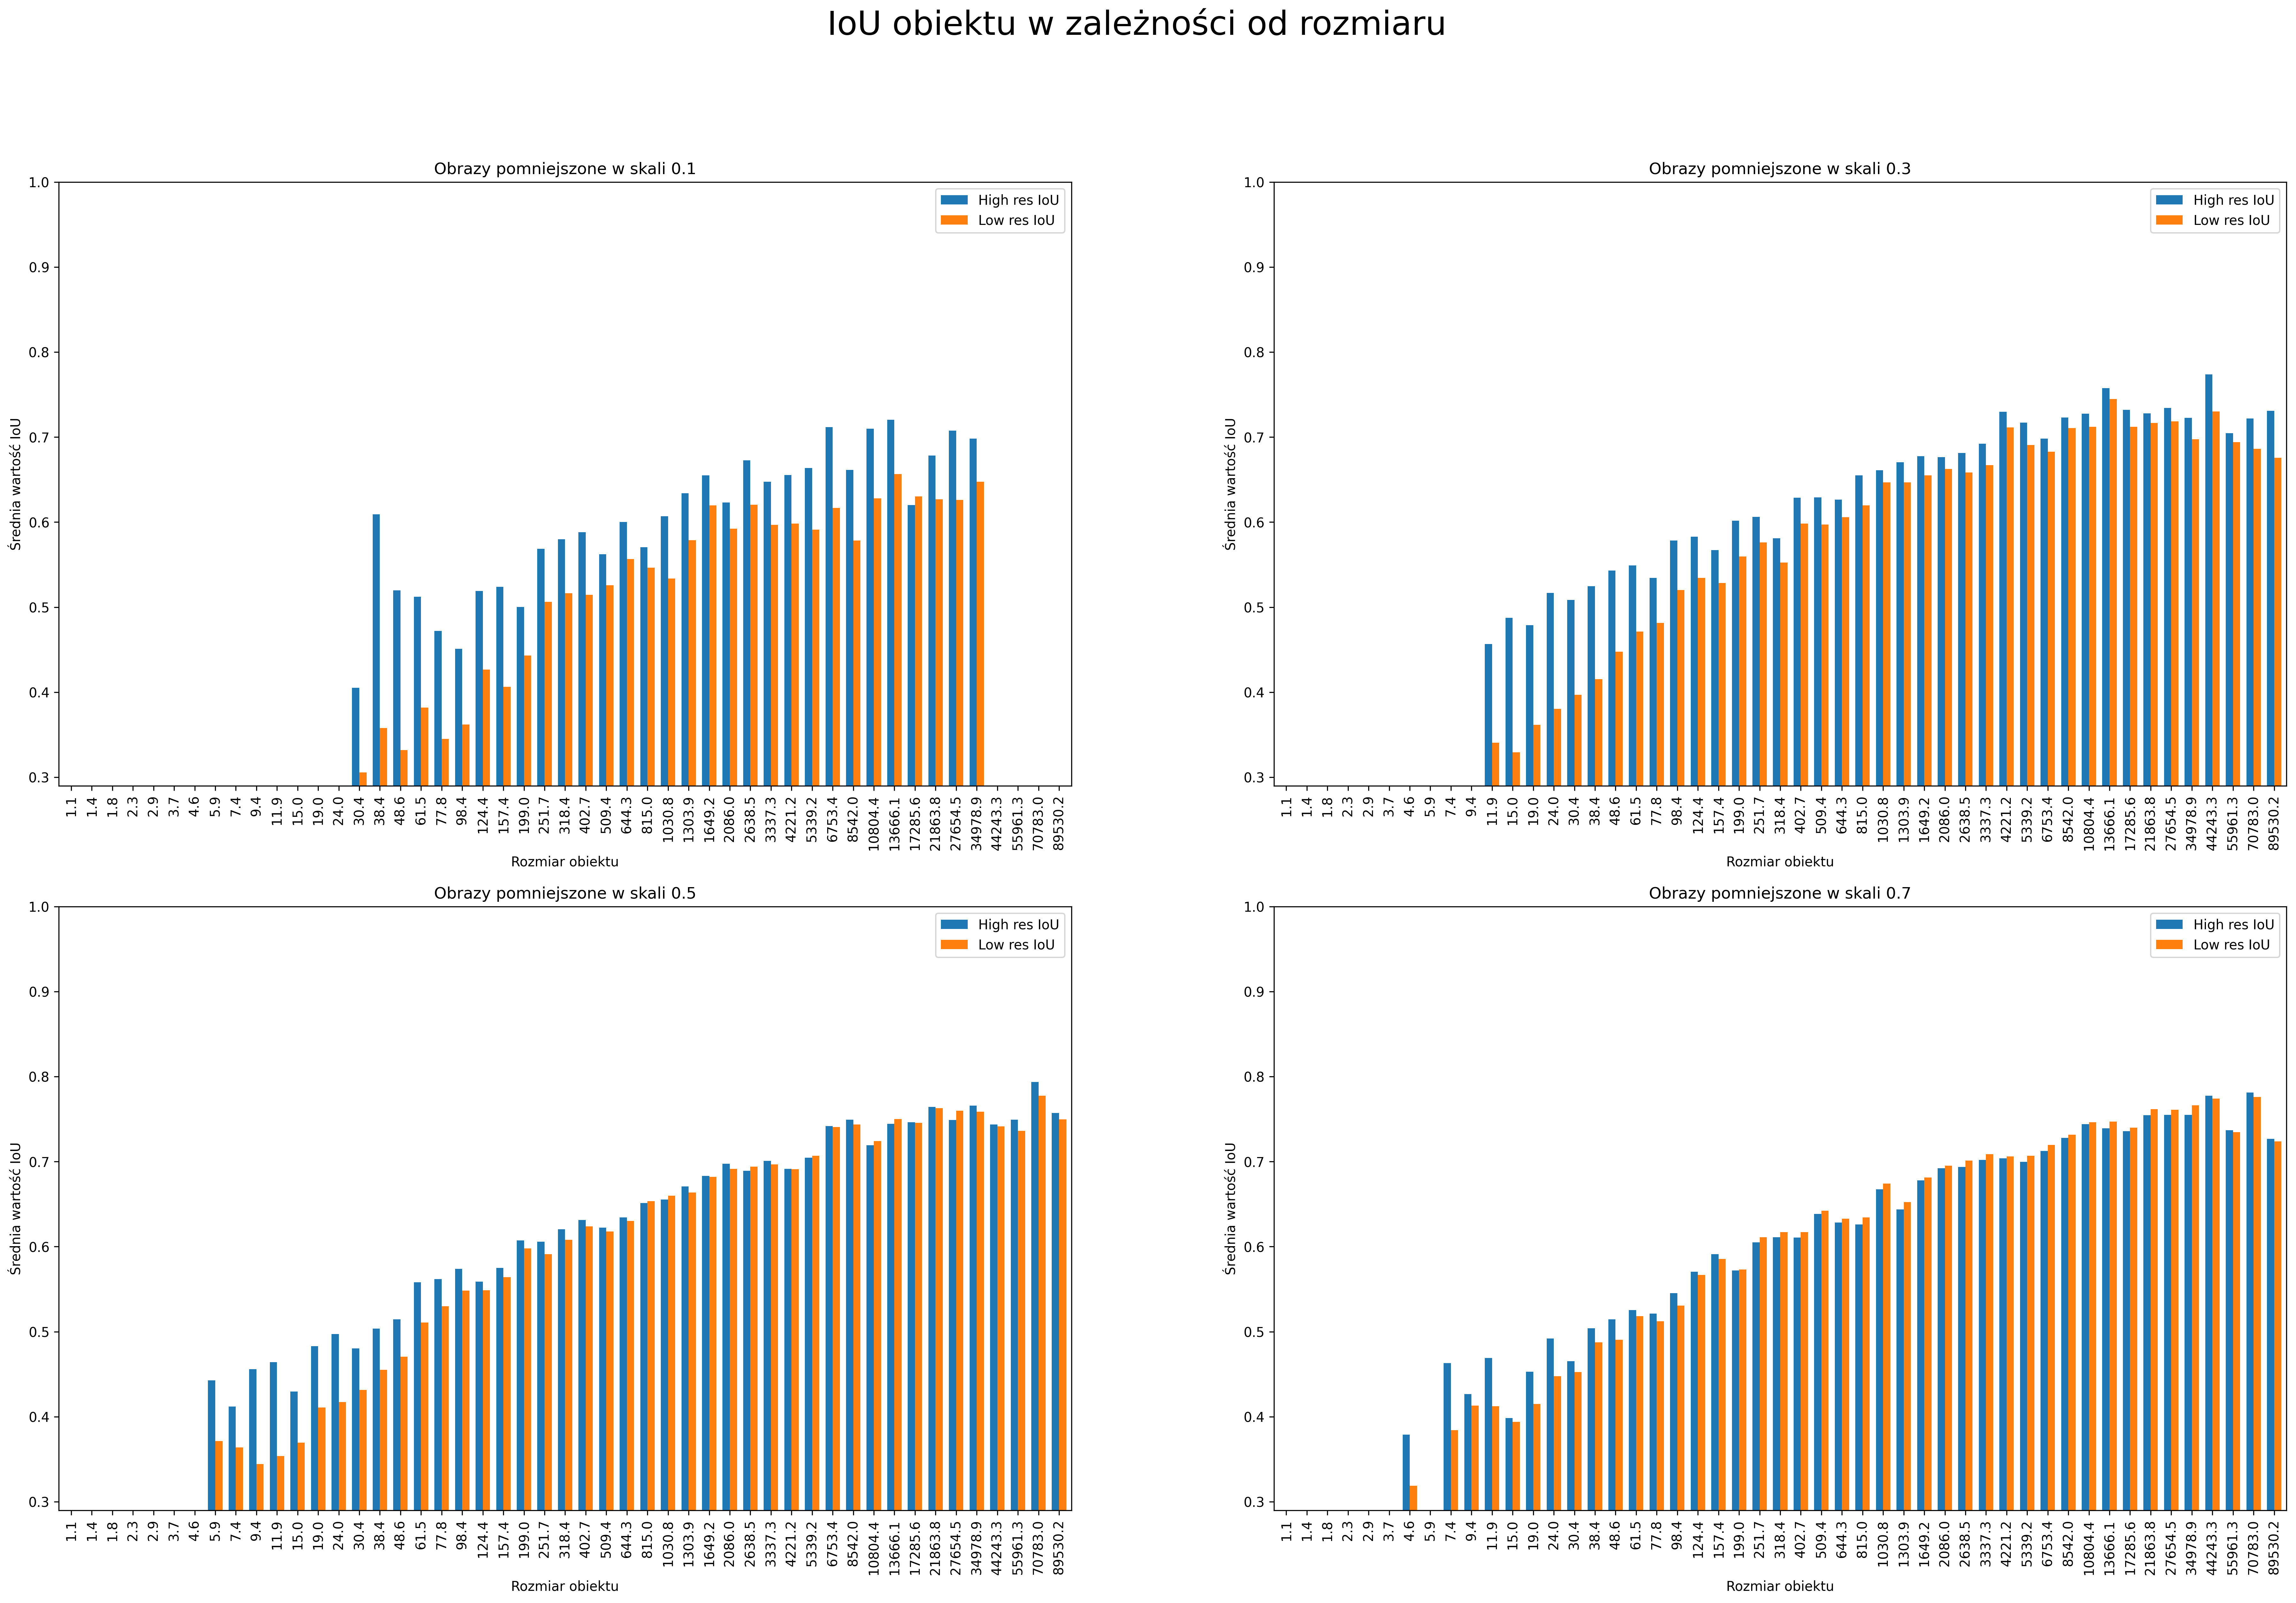

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(30,18), dpi=300)
scales = [0.1, 0.3, 0.5, 0.7]
for i, ds in enumerate(datasets):
    ds = ds[ds["Low res det"]]
    ds = ds[ds["High res det"]]
    ds = ds[['High res IoU', 'Low res IoU', "Obj size"]]
    ranges = np.logspace(np.log10(1),np.log10(100000.0), 50)


    answ = ds.groupby(pd.cut(ds['Obj size'], ranges)).mean()[['High res IoU', 'Low res IoU']]
    answ.index = answ.index.map(lambda i: np.around(i.mid, 1))
    answ.plot(kind="bar",xlim=True, ax=ax[int(i/2), i%2], width=0.7)

    ax[int(i/2), i%2].title.set_text("Obrazy pomniejszone w skali " + str(scales[i]))
    ax[int(i/2), i%2].set_xlabel("Rozmiar obiektu")

    ax[int(i/2), i%2].set_ylabel("Średnia wartość IoU")
    ax[int(i/2), i%2].set_ylim([0.29, 1])

    h_res_mean = answ["High res IoU"].mean()
    h_res_std = answ["High res IoU"].std()
    print("High " + str(scales[i]) + " Mean: " + str(h_res_mean) + " Std: " + str(h_res_std))

    l_res_mean = answ["Low res IoU"].mean()
    l_res_std = answ["Low res IoU"].std()
    print("Low " + str(scales[i]) + " Mean: " + str(l_res_mean) + " Std: " + str(l_res_std))

fig.suptitle("IoU obiektu w zależności od rozmiaru", fontsize=25)

In [ ]:
ds.sort_values("Obj img scale")

High res IoU  Low res IoU  Obj img scale
3116      0.000000     0.000000   0.000000e+00
5413      0.000000     0.000000   7.490412e-07
2609      0.000000     0.000000   1.328656e-06
4172      0.000000     0.000000   1.328656e-06
4820      0.000000     0.000000   2.239608e-06
...            ...          ...            ...
6838      0.849932     0.472567   1.384304e-01
5531      0.601201     0.615747   1.391269e-01
2671      0.645312     0.782843   1.400151e-01
6222      0.741200     0.738703   1.429131e-01
6483      0.581295     0.623507   1.432886e-01

[7159 rows x 3 columns]

High 0.1 Mean: 0.6752980002597584 Std: 0.0775438734550757
Low 0.1 Mean: 0.605543345505685 Std: 0.0723500573449184
High 0.3 Mean: 0.7188400473059393 Std: 0.04121940765927083
Low 0.3 Mean: 0.7011373743518384 Std: 0.04314416758855897
High 0.5 Mean: 0.7320598930490695 Std: 0.03937351613570724
Low 0.5 Mean: 0.731758304132085 Std: 0.040977112887307945
High 0.7 Mean: 0.7259286546379337 Std: 0.03873909125637788
Low 0.7 Mean: 0.7314402180887973 Std: 0.03877256417516504


Text(0.5, 0.98, 'IoU obiektu w zależności od stosunku rozmiaru obiektu do obrazka')

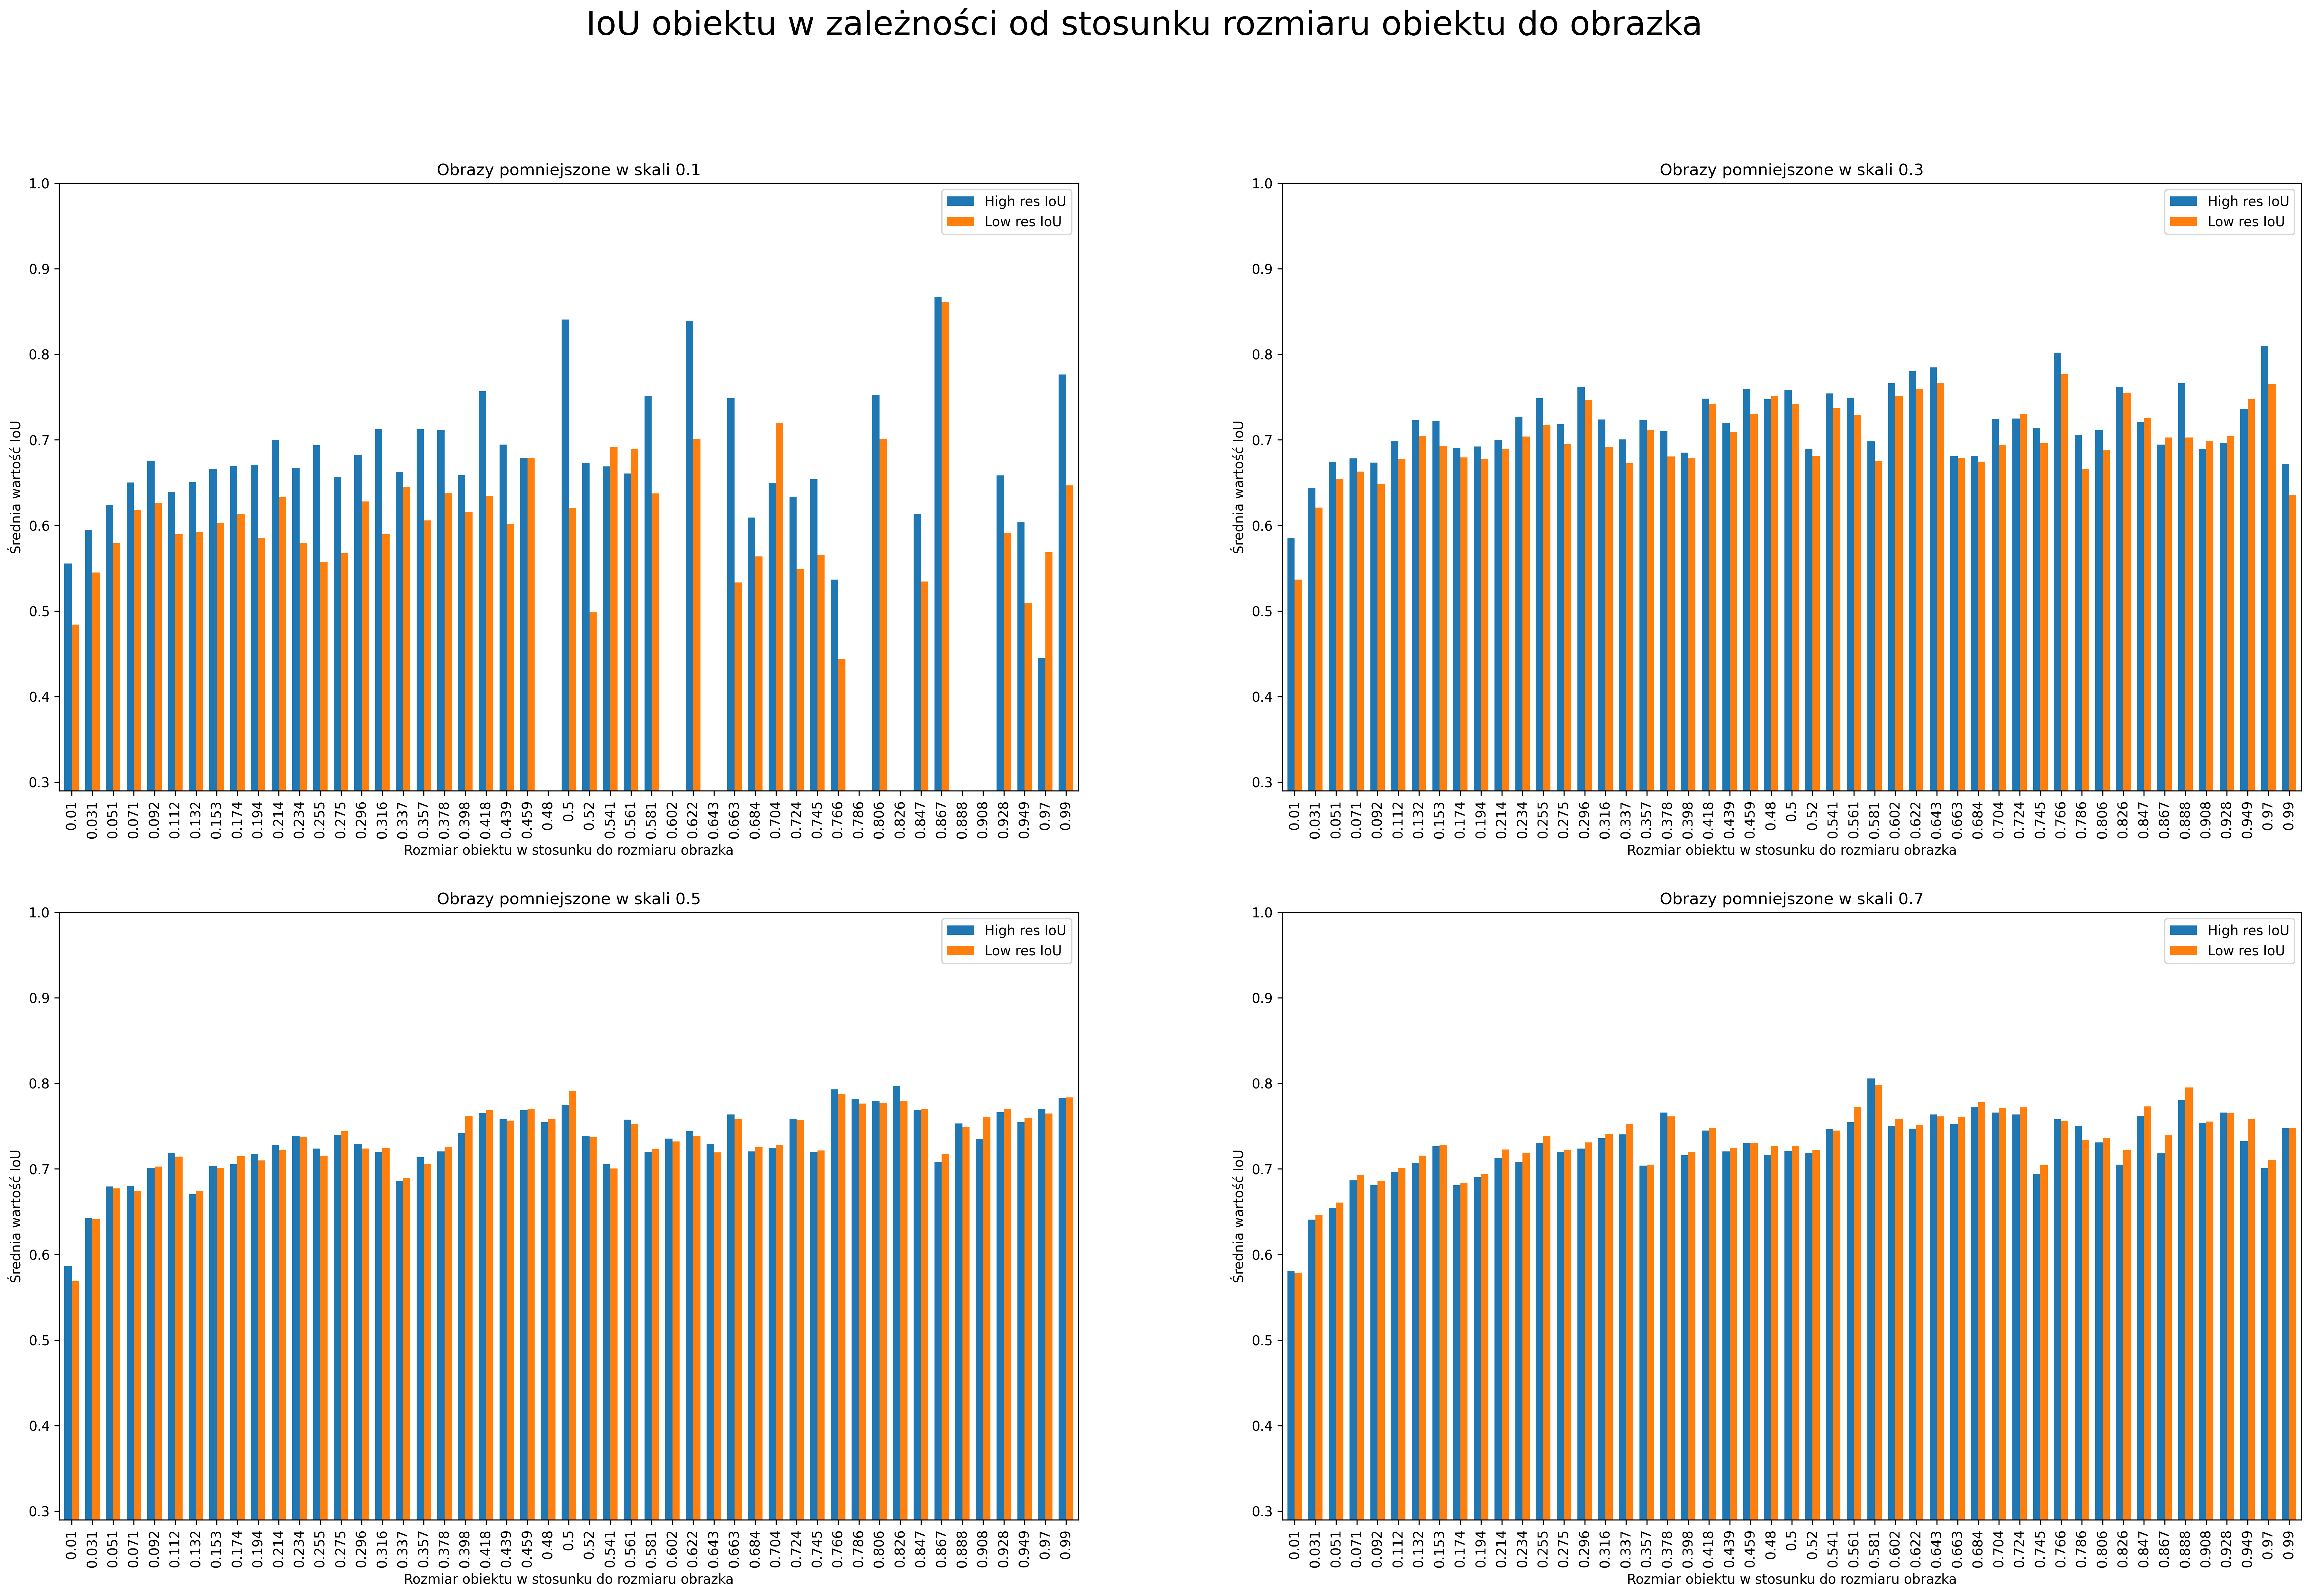

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(30,18), dpi=300)
scales = [0.1, 0.3, 0.5, 0.7]
for i, ds in enumerate(datasets):

    ds["Img size"] = imsizes
    ds["Obj img scale"] = ds["Obj size"] / ds["Img size"]
    ranges = np.linspace(0, 1, 50)

    ds = ds[ds["Low res det"]]
    ds = ds[ds["High res det"]]
    ds = ds[['High res IoU', 'Low res IoU', "Obj img scale"]]

    answ = ds.groupby(pd.cut(ds['Obj img scale'], ranges)).mean()[['High res IoU', 'Low res IoU']]
    answ.index = answ.index.map(lambda i: np.around(i.mid, 3))
    answ.plot(kind="bar", ax=ax[int(i/2), i%2], width=0.7)

    ax[int(i/2), i%2].title.set_text("Obrazy pomniejszone w skali " + str(scales[i]))
    ax[int(i/2), i%2].set_xlabel("Rozmiar obiektu w stosunku do rozmiaru obrazka")

    ax[int(i/2), i%2].set_ylabel("Średnia wartość IoU")
    ax[int(i/2), i%2].set_ylim([0.29, 1])

    h_res_mean = answ["High res IoU"].mean()
    h_res_std = answ["High res IoU"].std()
    print("High " + str(scales[i]) + " Mean: " + str(h_res_mean) + " Std: " + str(h_res_std))

    l_res_mean = answ["Low res IoU"].mean()
    l_res_std = answ["Low res IoU"].std()
    print("Low " + str(scales[i]) + " Mean: " + str(l_res_mean) + " Std: " + str(l_res_std))

fig.suptitle("IoU obiektu w zależności od stosunku rozmiaru obiektu do obrazka", fontsize=25)

# Detekcja w zależności od klasy obiektu

In [ ]:
ds = datasets[0]
ds = ds[['High res det', 'Low res det', "Name"]]

ds = ds.groupby('Name').filter(lambda x : len(x)>10)
ds
# answ = ds.groupby(ds['Name']).mean()[['High res det', 'Low res det']]
# answ = answ.sort_values('High res det', ascending= False )
# answ.plot(kind="bar", ax=ax[int(i/2), i%2], width=0.7)

High res det  Low res det          Name
0            False         True  potted plant
1             True         True            tv
2            False        False            tv
3            False         True         chair
4            False        False         chair
...            ...          ...           ...
7154          True         True        laptop
7155         False        False           cup
7156         False        False         spoon
7157         False        False         spoon
7158         False        False    cell phone

[7142 rows x 3 columns]

High 0.1 Mean: 0.2672716478004332 Std: 0.1657848213163045
Low 0.1 Mean: 0.15473104598625442 Std: 0.16047355816374875
High 0.3 Mean: 0.6393848875618239 Std: 0.16245064556889754
Low 0.3 Mean: 0.5683490762868751 Std: 0.19815063615815484
High 0.5 Mean: 0.7684937067830278 Std: 0.1349305447832757
Low 0.5 Mean: 0.7532721169538241 Std: 0.1496741526524362
High 0.7 Mean: 0.8027910949441902 Std: 0.12082305142755793
Low 0.7 Mean: 0.8040680526266742 Std: 0.1261205477207674


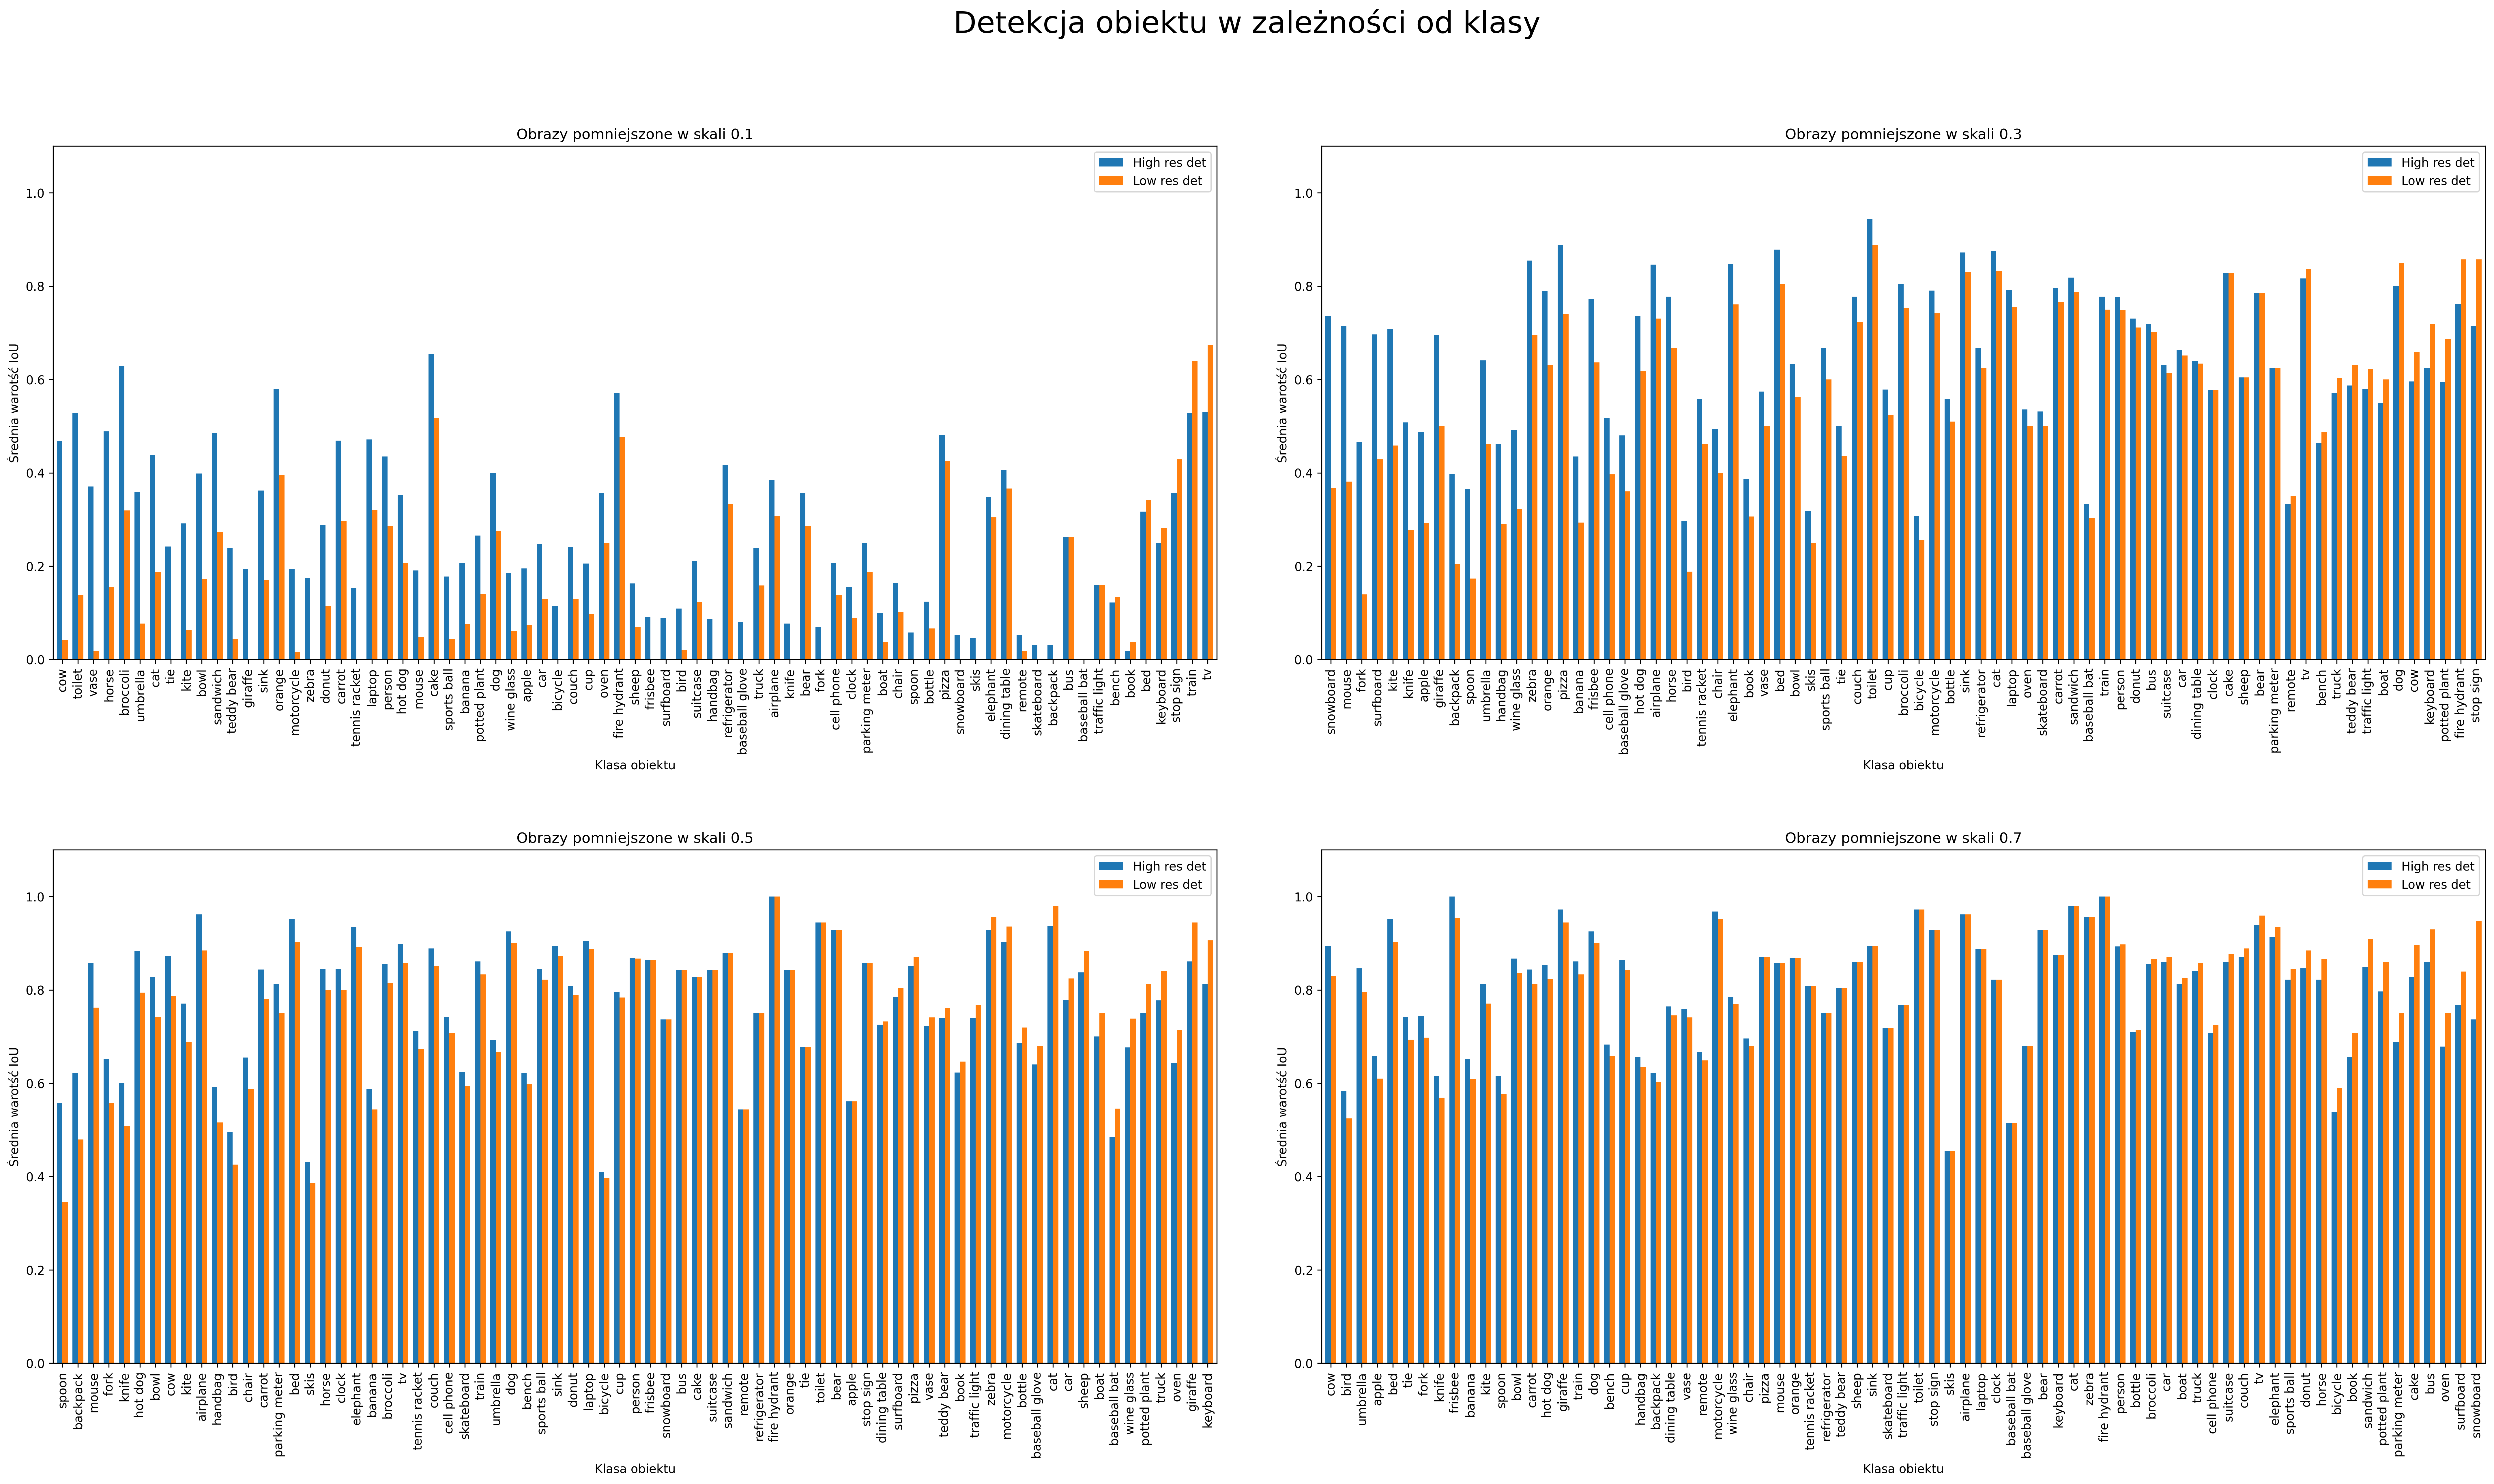

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(30,18), dpi=300)
scales = [0.1, 0.3, 0.5, 0.7]
for i, ds in enumerate(datasets):
    ds = ds[['High res det', 'Low res det', "Name"]]
    ds = ds.groupby('Name').filter(lambda x : len(x)>10)


    answ = ds.groupby(ds['Name']).mean()[['High res det', 'Low res det']]
    answ["diff"] = answ['High res det'] - answ['Low res det']
    answ = answ.sort_values('diff', ascending= False )[['High res det', 'Low res det']]
    answ.plot(kind="bar", ax=ax[int(i/2), i%2], width=0.7)

    ax[int(i/2), i%2].title.set_text("Obrazy pomniejszone w skali " + str(scales[i]))
    ax[int(i/2), i%2].set_xlabel("Klasa obiektu")

    ax[int(i/2), i%2].set_ylabel("Średnia warotść IoU")
    ax[int(i/2), i%2].set_ylim([0, 1.1])

    h_res_mean = answ["High res det"].mean()
    h_res_std = answ["High res det"].std()
    print("High " + str(scales[i]) + " Mean: " + str(h_res_mean) + " Std: " + str(h_res_std))

    l_res_mean = answ["Low res det"].mean()
    l_res_std = answ["Low res det"].std()
    print("Low " + str(scales[i]) + " Mean: " + str(l_res_mean) + " Std: " + str(l_res_std))

fig.suptitle("Detekcja obiektu w zależności od klasy", fontsize=25)
fig.tight_layout(pad=5.0)


# IoU w zależności od klasy obiektu

High 0.1 Mean: 0.6775419047548715 Std: 0.09610244778352205
Low 0.1 Mean: 0.6131386171408779 Std: 0.11333227808771733
High 0.3 Mean: 0.6771061431382047 Std: 0.09360903631449868
Low 0.3 Mean: 0.6470237197918798 Std: 0.10005429455354259
High 0.5 Mean: 0.681530060800845 Std: 0.09288635016539463
Low 0.5 Mean: 0.6751928361099548 Std: 0.09369587776533754
High 0.7 Mean: 0.6821937357484299 Std: 0.0925059099294254
Low 0.7 Mean: 0.6854551880578883 Std: 0.09184562674139239


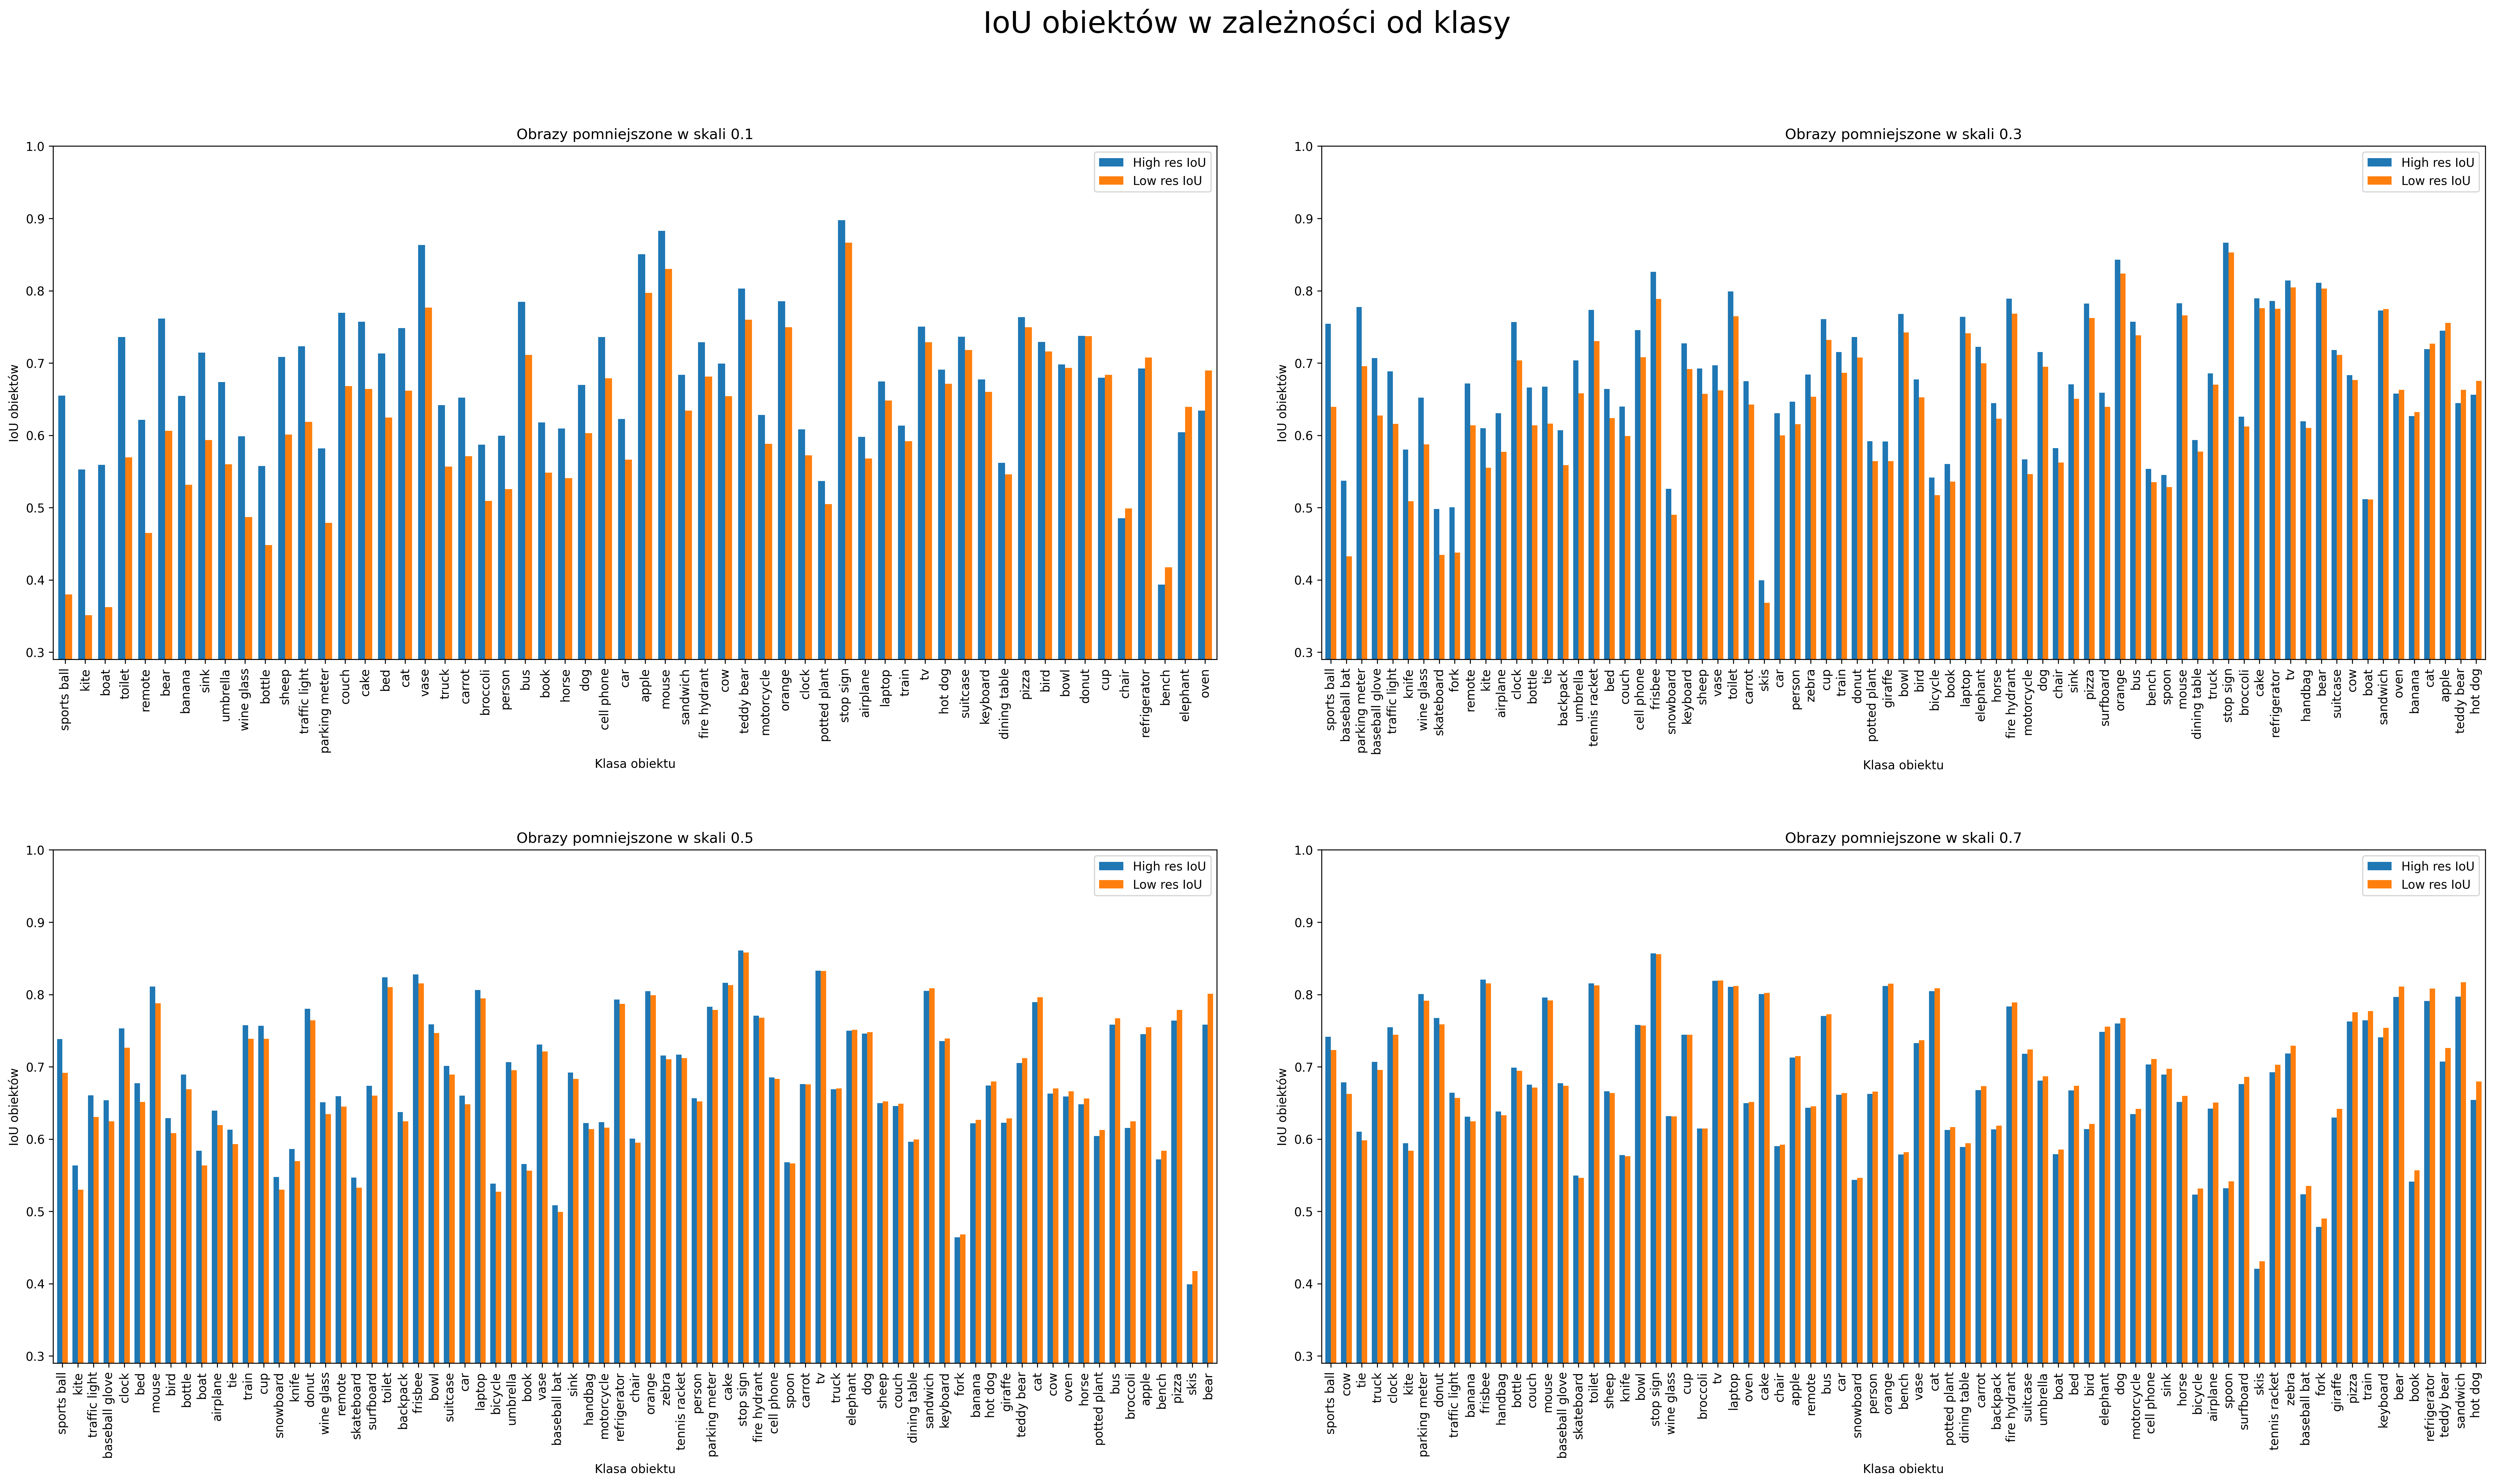

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(30,18), dpi=300)
scales = [0.1, 0.3, 0.5, 0.7]
for i, ds in enumerate(datasets):
    ds = ds.groupby('Name').filter(lambda x : len(x)>10)
    ds = ds[ds["Low res det"]]
    ds = ds[ds["High res det"]]
    ds = ds[['High res IoU', 'Low res IoU', "Name"]]


    answ = ds.groupby(ds['Name']).mean()[['High res IoU', 'Low res IoU']]
    answ["diff"] = answ['High res IoU'] - answ['Low res IoU']
    answ = answ.sort_values('diff', ascending= False )[['High res IoU', 'Low res IoU']]
    answ.plot(kind="bar", ax=ax[int(i/2), i%2], width=0.7)

    ax[int(i/2), i%2].title.set_text("Obrazy pomniejszone w skali " + str(scales[i]))
    ax[int(i/2), i%2].set_xlabel("Klasa obiektu")

    ax[int(i/2), i%2].set_ylabel("IoU obiektów")
    ax[int(i/2), i%2].set_ylim([0.29, 1])

    h_res_mean = answ["High res IoU"].mean()
    h_res_std = answ["High res IoU"].std()
    print("High " + str(scales[i]) + " Mean: " + str(h_res_mean) + " Std: " + str(h_res_std))

    l_res_mean = answ["Low res IoU"].mean()
    l_res_std = answ["Low res IoU"].std()
    print("Low " + str(scales[i]) + " Mean: " + str(l_res_mean) + " Std: " + str(l_res_std))

fig.suptitle("IoU obiektów w zależności od klasy", fontsize=25)
fig.tight_layout(pad=5.0)


# Rozkład rozmiarów i kategorii obiektów

Text(0, 0.5, 'Liczba obiektów w danej kategorii')

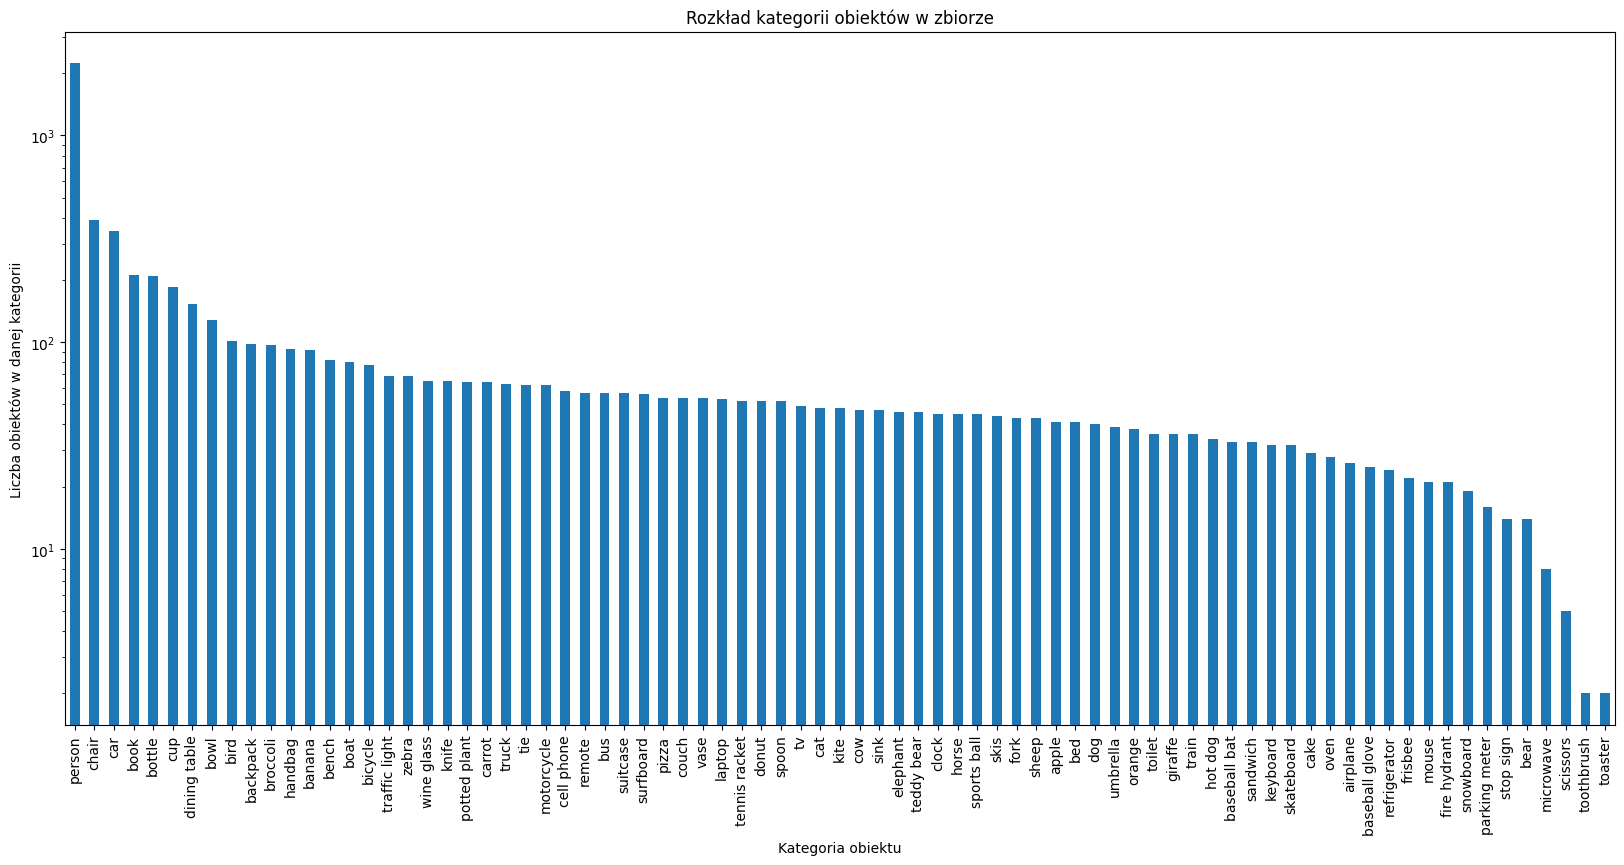

In [ ]:
d_t = datasets[0]

figure, ax = plt.subplots(1, 1, figsize=(20,9), dpi = 100)
d_t["Name"].value_counts().plot(kind="bar", title="Rozkład kategorii obiektów w zbiorze", ax=ax, logy=True)
ax.set_xlabel("Kategoria obiektu")
ax.set_ylabel("Liczba obiektów w danej kategorii")

(1250.1380081016903, 3004.910658832884)

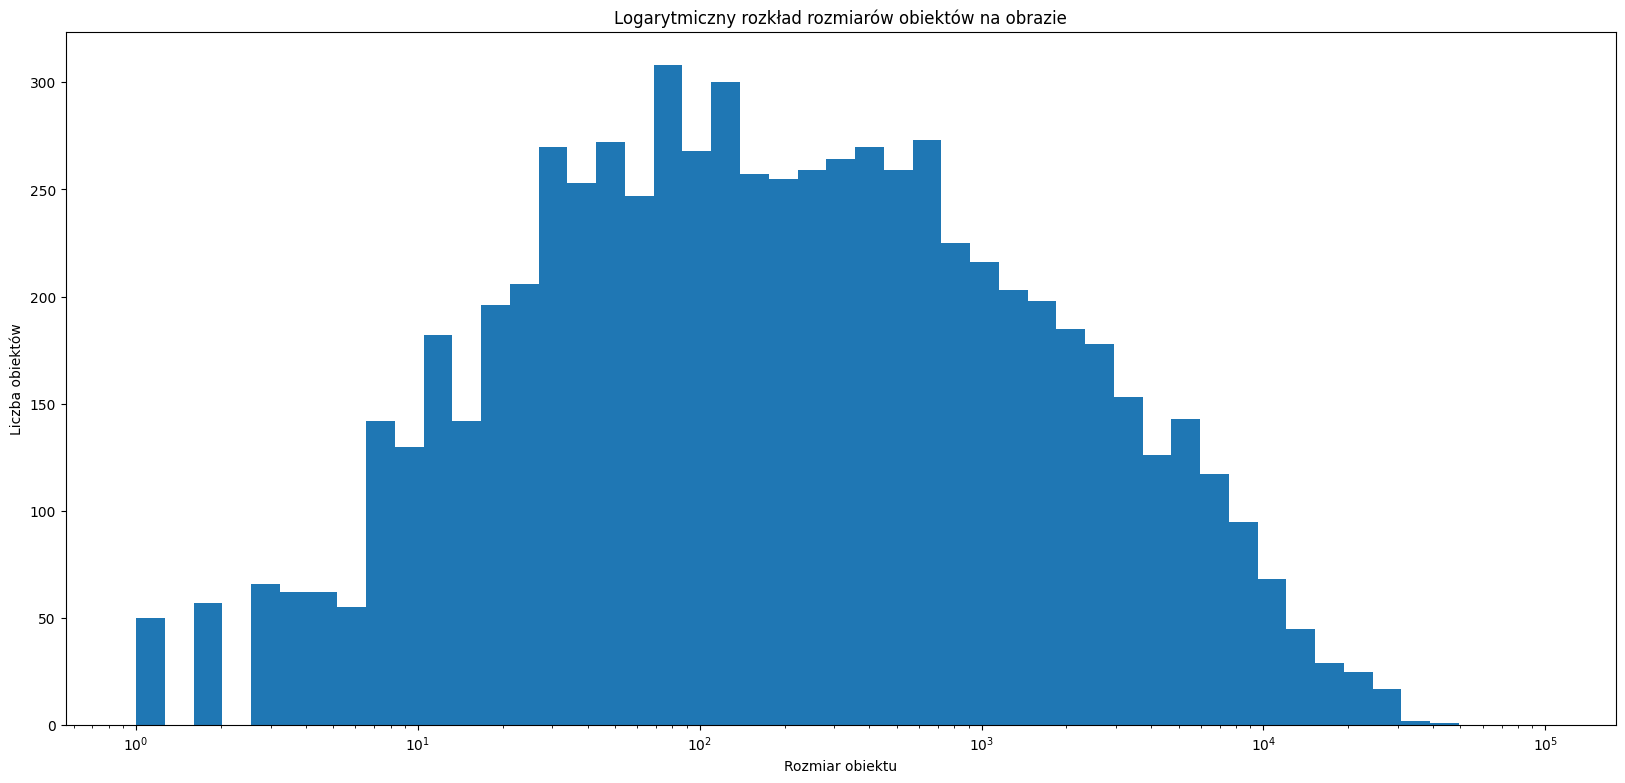

In [ ]:
d_t = datasets[0]

imsizes=[]
for i in datasets[0]["Shape"]:
    imsizes.append(i[0] * i[1])

d_t["Img size"] = imsizes
# d_t["Obj img scale"] = d_t["Obj size"] / d_t["Img size"]
figure, ax = plt.subplots(1, 1, figsize=(20,9), dpi = 100)
d_t["Obj size"].plot(kind="hist", bins=np.logspace(np.log10(1),np.log10(100000.0), 50), logx=True, title="Logarytmiczny rozkład rozmiarów obiektów na obrazie", ax=ax)
ax.set_xlabel("Rozmiar obiektu")
ax.set_ylabel("Liczba obiektów")

d_t["Obj size"].mean(), d_t["Obj size"].std()




# Średnia i odchylenie

In [ ]:
def plot_mean_with_std_dev(datasets):
    iou_mean = [[],[]]
    for ds in datasets:
        iou_mean[0].append(ds["Low res IoU"].mean())
        iou_mean[1].append(ds["High res IoU"].mean())
    iou_mean

    iou_std = [[],[]]
    for ds in datasets:
        iou_std[0].append(ds_iou["Low res IoU"].std())
        iou_std[1].append(ds_iou["High res IoU"].std())
    iou_std

    plotdata = pd.DataFrame({
    "Obraz w małej rozdzielczości":iou_mean[0],
    "Obraz z podniesioną rozdzielczością":iou_mean[1]},

    index=["0.1", "0.3", "0.5", "0.7"])
    print(iou_std)
    plotdata.plot(kind="bar",figsize=(15, 8), yerr=iou_std)

    plt.title("Zależnośc średniej wartości IoU od przeskalowania obrazków")

    plt.xlabel("Skala Pomniejszenia obrazu")

    plt.ylabel("Średnia wartośc Iou")


[[0.14847151441744055, 0.14847151441744055, 0.14847151441744055, 0.14847151441744055], [0.15025581579694008, 0.15025581579694008, 0.15025581579694008, 0.15025581579694008]]


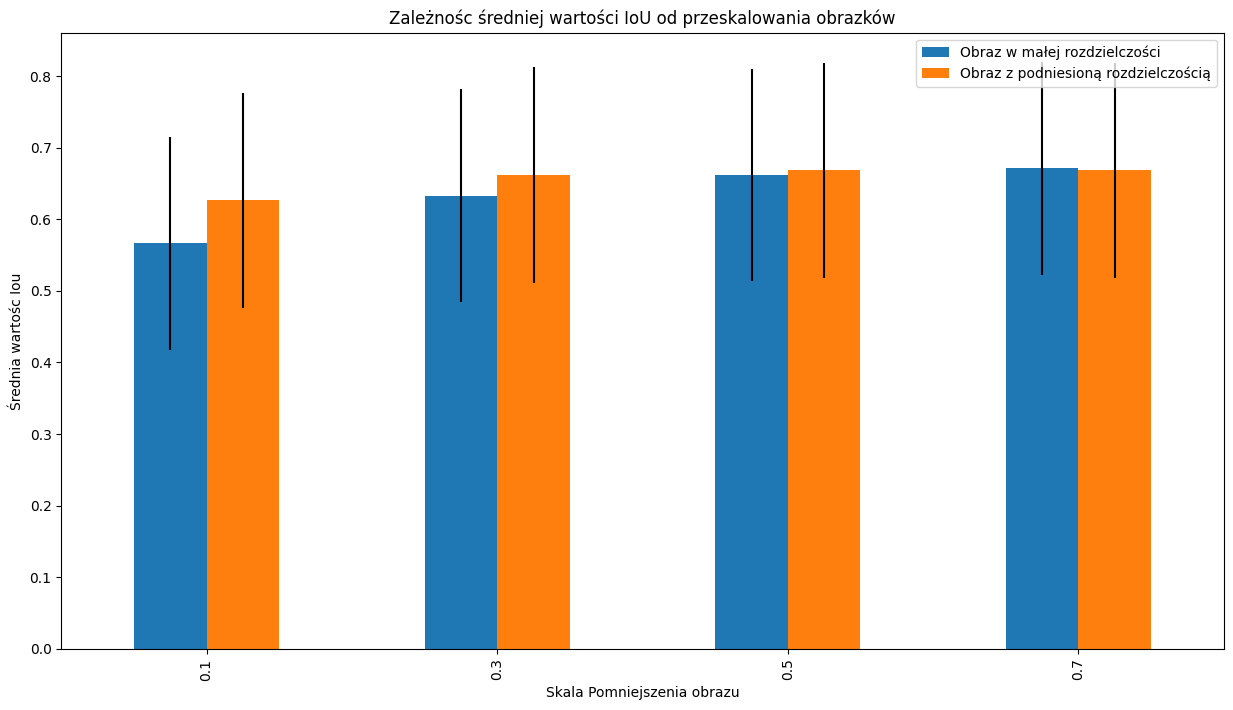

In [ ]:
datasets_iou = []
for ds in datasets:
    ds_iou = ds[ds["Low res det"]]
    ds_iou = ds_iou[ds_iou["High res det"]]
    datasets_iou.append(ds_iou)
plot_mean_with_std_dev(datasets_iou)

In [ ]:
d_t = datasets[0]
d_t[d_t["Obj size"] < d_t["Obj size"].median()]


Unnamed: 0  Low res det  Low res IoU  Low res time  High res det  \
0              0         True     0.322917      0.198776         False   
5              5        False     0.000000      0.198776         False   
6              6        False     0.000000      0.198776         False   
8              8        False     0.000000      0.198776         False   
9              9        False     0.000000      0.198776         False   
...          ...          ...          ...           ...           ...   
7152        7152        False     0.000000      0.138973         False   
7153        7153        False     0.000000      0.138973         False   
7156        7156        False     0.000000      0.138973         False   
7157        7157        False     0.000000      0.138973         False   
7158        7158        False     0.000000      0.138973         False   

      High res IoU  High res time  Obj size        Shape          Name  \
0              0.0       0.210803        53  (42, 64, 3)  potted plant   
5              0.0       0.210803       129  (42, 64, 3)         chair   
6              0.0       0.210803        18  (42, 64, 3)         chair   
8              0.0       0.210803        39  (42, 64, 3)        person   
9              0.0       0.210803        20  (42, 64, 3)     microwave   
...            ...            ...       ...          ...           ...   
7152           0.0       0.220532        34  (33, 50, 3)         spoon   
7153           0.0       0.220532        11  (33, 50, 3)         spoon   
7156           0.0       0.220532        16  (33, 50, 3)         spoon   
7157           0.0       0.220532         7  (33, 50, 3)         spoon   
7158           0.0       0.220532       101  (33, 50, 3)    cell phone   

              Filepath  
0     000000000139.jpg  
5     000000000139.jpg  
6     000000000139.jpg  
8     000000000139.jpg  
9     000000000139.jpg  
...                ...  
7152  000000119233.jpg  
7153  000000119233.jpg  
7156  000000119233.jpg  
7157  000000119233.jpg  
7158  000000119233.jpg  

[3573 rows x 11 columns]

[[0.14847151441744055, 0.14847151441744055, 0.14847151441744055, 0.14847151441744055], [0.15025581579694008, 0.15025581579694008, 0.15025581579694008, 0.15025581579694008]]


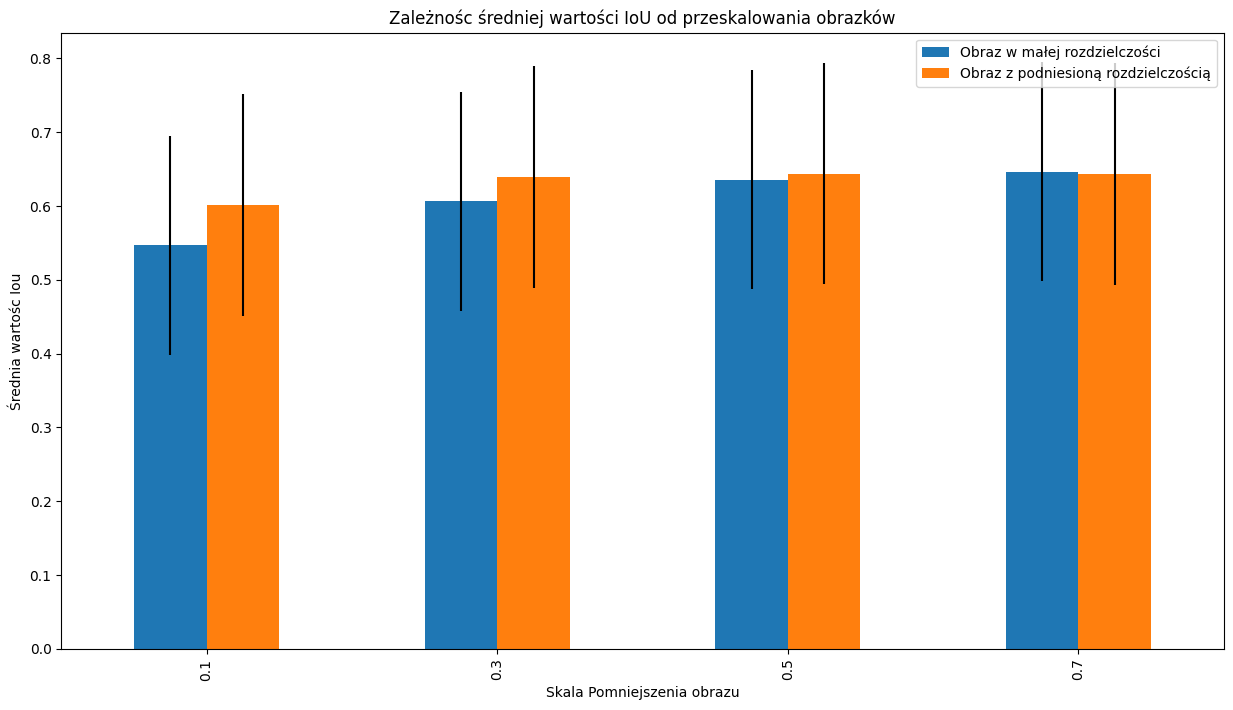

In [ ]:
datasets_iou = []
for ds in datasets:
    ds_iou = ds[ds["Low res det"]]
    ds_iou = ds_iou[ds_iou["High res det"]]
    ds_small = ds_iou[ds_iou["Obj size"] < ds_iou["Obj size"].mean()]
    datasets_iou.append(ds_small)
plot_mean_with_std_dev(datasets_iou)

[[0.14847151441744055, 0.14847151441744055, 0.14847151441744055, 0.14847151441744055], [0.15025581579694008, 0.15025581579694008, 0.15025581579694008, 0.15025581579694008]]


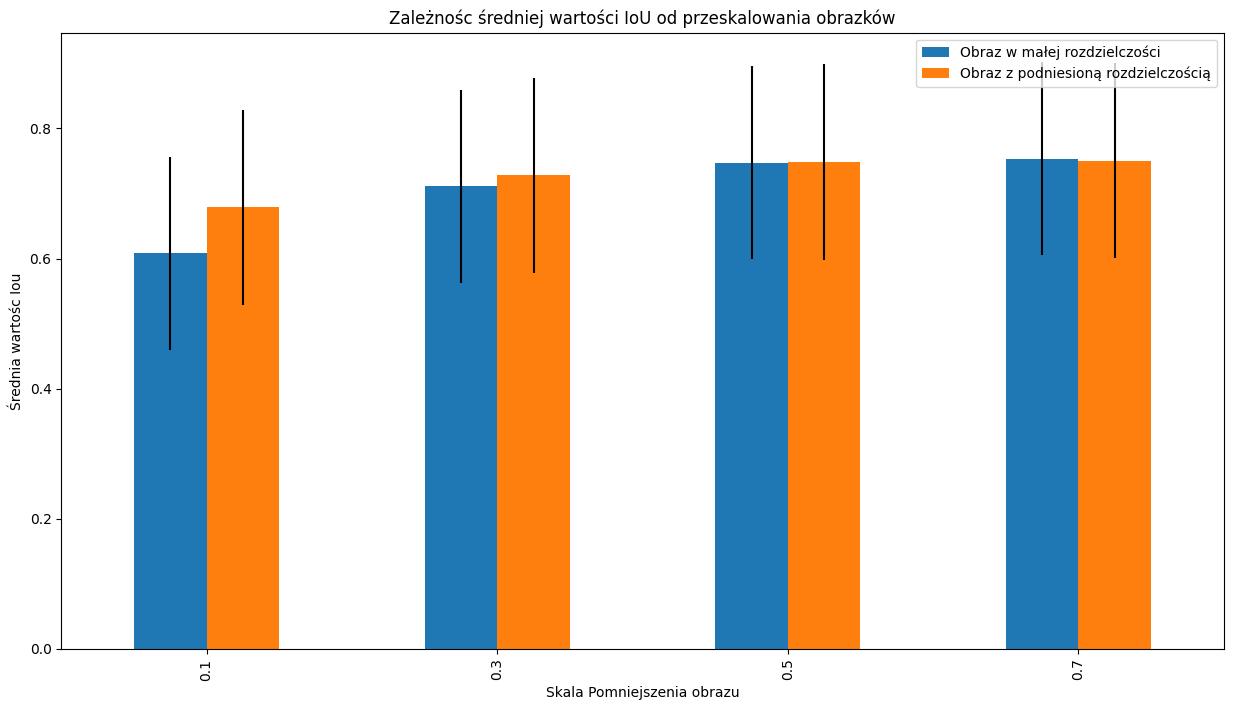

In [ ]:
datasets_iou = []
for ds in datasets:
    ds_iou = ds[ds["Low res det"]]
    ds_iou = ds_iou[ds_iou["High res det"]]
    ds_small = ds_iou[ds_iou["Obj size"] > ds_iou["Obj size"].mean()]
    datasets_iou.append(ds_small)
plot_mean_with_std_dev(datasets_iou)

In [ ]:
iou_median = [[],[]]
for ds in datasets:
    ds_iou = ds[ds["Low res det"]]
    ds_iou = ds_iou[ds_iou["High res det"]]
    iou_median[0].append(ds_iou["Low res IoU"].median())
    iou_median[1].append(ds_iou["High res IoU"].median())
iou_median

[[0.5605993636780972,
  0.6451830475407119,
  0.6805691486279084,
  0.6938376002019827],
 [0.6348015819752701,
  0.6789016570085832,
  0.6899693036906691,
  0.690112810129223]]

In [ ]:
iou_median = [[],[]]
for ds in datasets:
    ds_iou = ds[ds["Low res det"]]
    ds_iou = ds_iou[ds_iou["High res det"]]
    ds_small = ds_iou[ds_iou["Obj size"] < ds_iou["Obj size"].mean()]
    iou_median[0].append(ds_small["Low res IoU"].median())
    iou_median[1].append(ds_small["High res IoU"].median())
iou_median

[[0.5408734830505513,
  0.6138754316372882,
  0.6513361207150833,
  0.6638887535406893],
 [0.6047286279549943,
  0.6502700420563244,
  0.6588845340376043,
  0.6618289988229212]]